# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
s = ApiKeyStore()
openai_api_key = s.get_api_key("OPENAI/Yiwen")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
from vanna.openai import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'gpt-4'  # 'gpt-3.5-turbo'
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': openai_api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model gpt-4 for 944.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model gpt-4 for 161.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['COUNT(*)'].values[0]
))

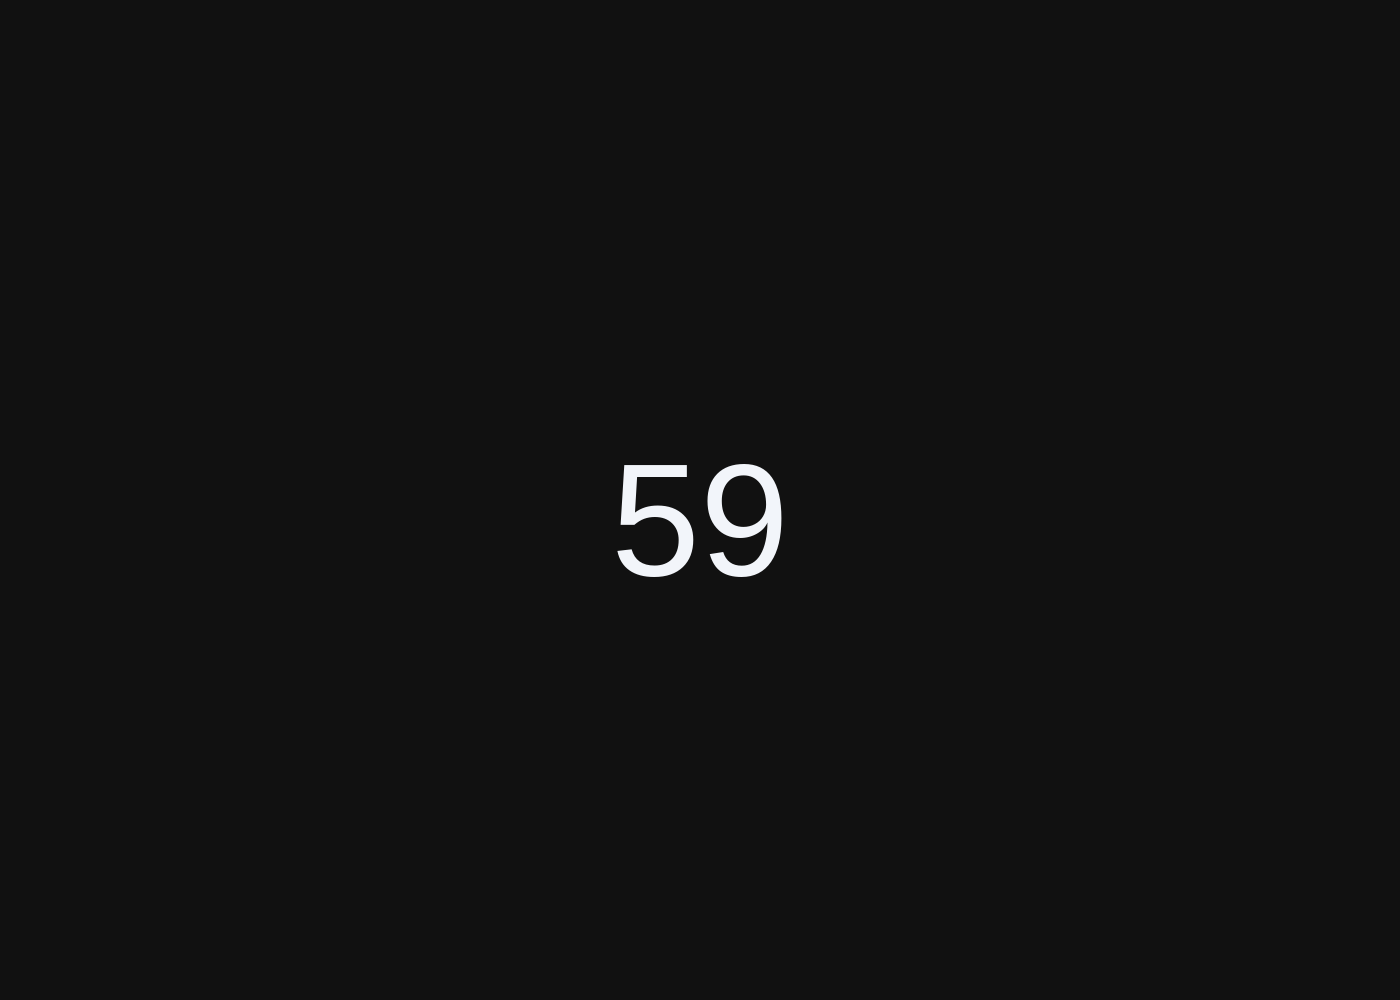

elapsed_time = 3.1708381175994873


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model gpt-4 for 861.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists


Using model gpt-4 for 172.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df['name'].unique()) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['name'].value_counts().values[0],
        title = {"text": df['name'].values[0]}))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['name'].value_counts().index,
        y=df['name'].value_counts().values
    )])

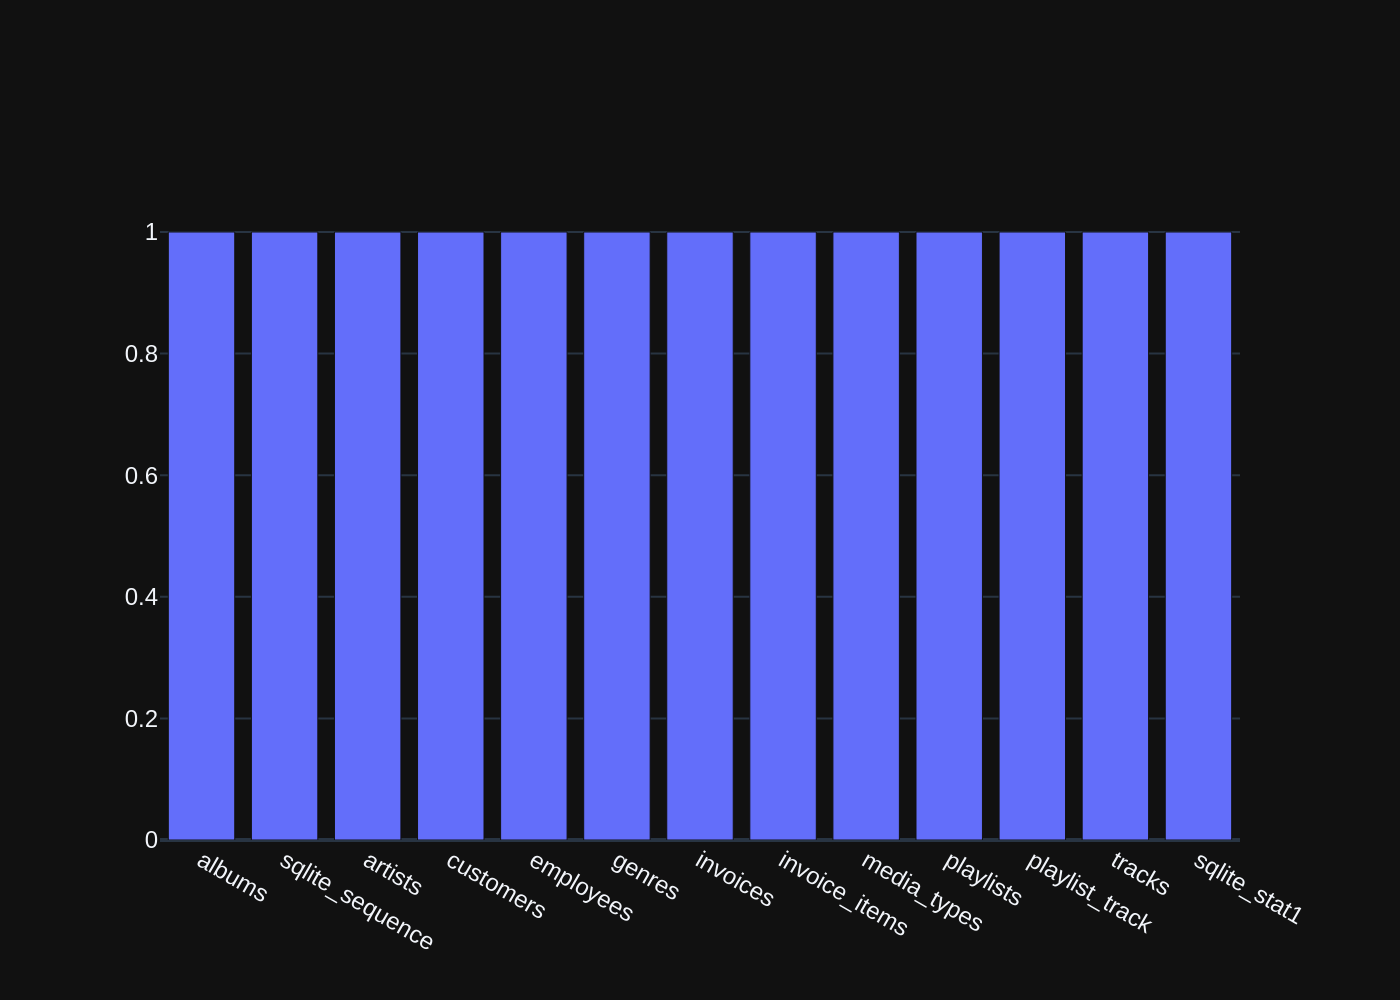





# QUESTION  - 3:  which table stores customer's orders


Using model gpt-4 for 1070.75 tokens (approx)

[( RETRY )]
***** 1 *****

Using model gpt-4 for 1045.75 tokens (approx)

[( RETRY )]
***** 2 *****

Using model gpt-4 for 1142.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM invoices LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
5,6,37,2009-01-19 00:00:00,Berger Straße 10,Frankfurt,None,Germany,60316,0.99
6,7,38,2009-02-01 00:00:00,Barbarossastraße 19,Berlin,None,Germany,10779,1.98
7,8,40,2009-02-01 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
8,9,42,2009-02-02 00:00:00,"9, Place Louis Barthou",Bordeaux,None,France,33000,3.96
9,10,46,2009-02-03 00:00:00,3 Chatham Street,Dublin,Dublin,Ireland,None,5.94


Using model gpt-4 for 392.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='CustomerId', y='Total', title="Customer's Orders")

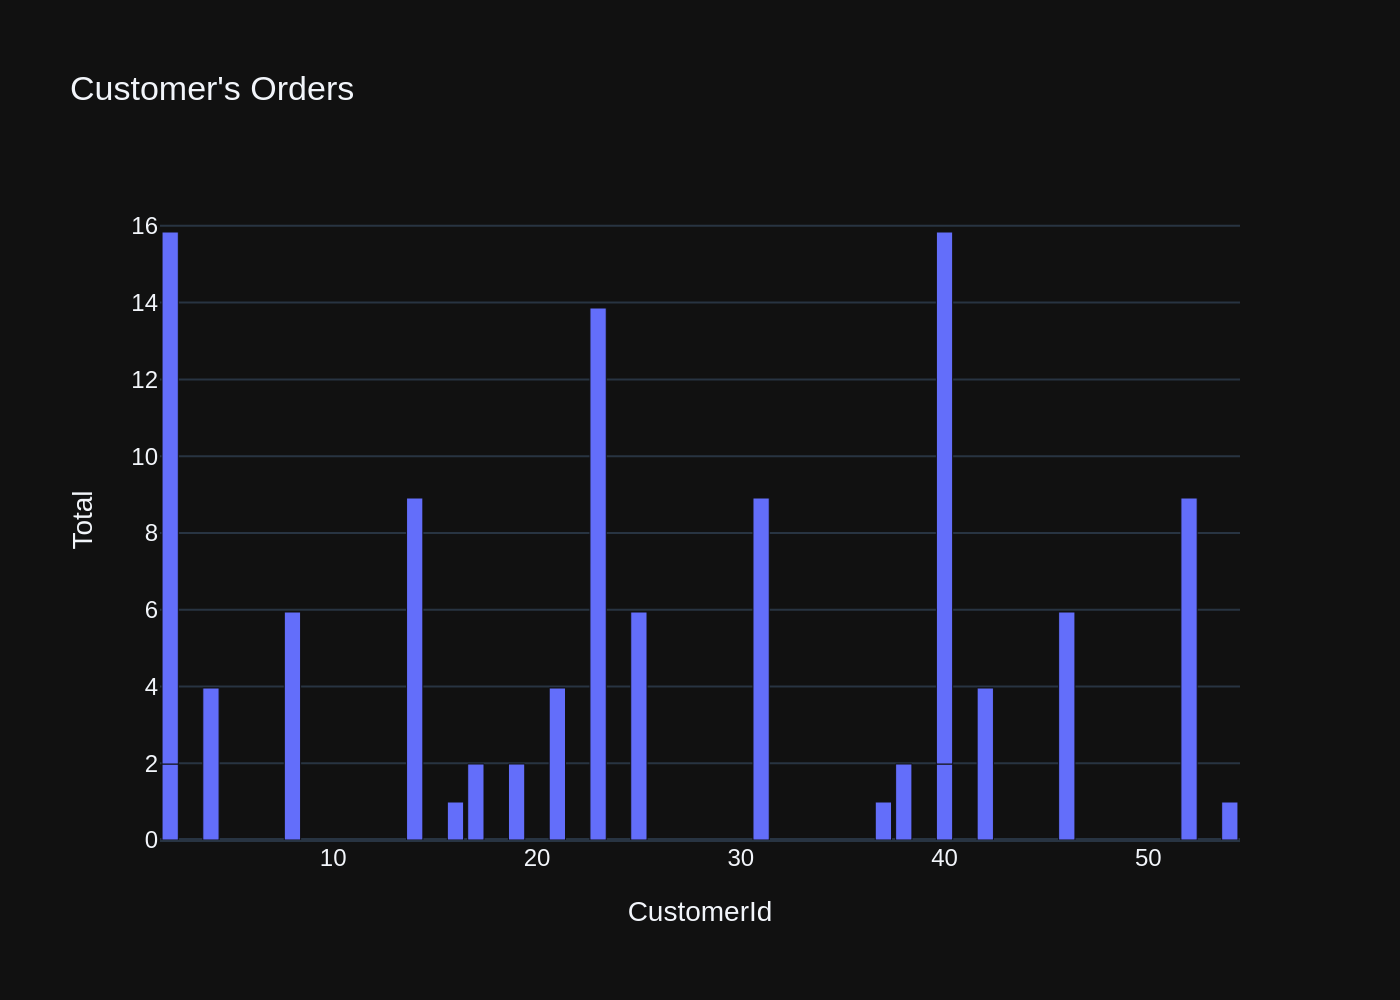





# QUESTION  - 4:  How many customers are there


Using model gpt-4 for 1176.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM customers LIMIT 20


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model gpt-4 for 161.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['COUNT(*)'].values[0]
))

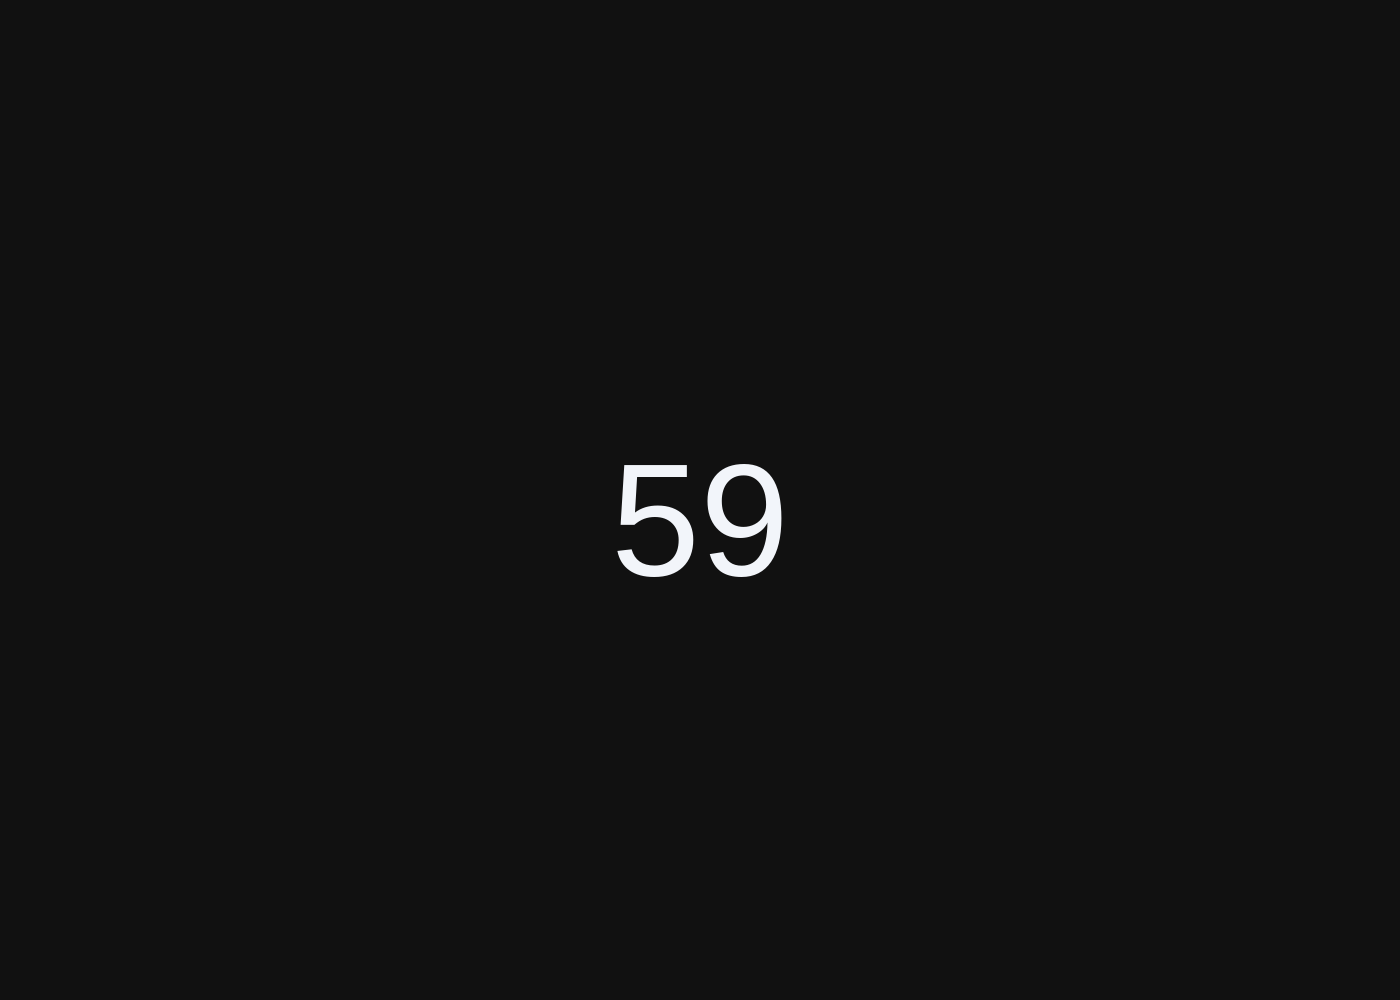





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model gpt-4 for 1401.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Country, COUNT(*) as NumberOfCustomers 
FROM customers 
GROUP BY Country 
ORDER BY NumberOfCustomers DESC 
LIMIT 5


[( <DataFrame> )]
queried dataframe



,Country,NumberOfCustomers
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model gpt-4 for 197.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title=df.iloc[0]['Country'], value=df.iloc[0]['NumberOfCustomers'])
else:
    fig = px.bar(df, x='Country', y='NumberOfCustomers', title='Top 5 Countries with Most Customers')

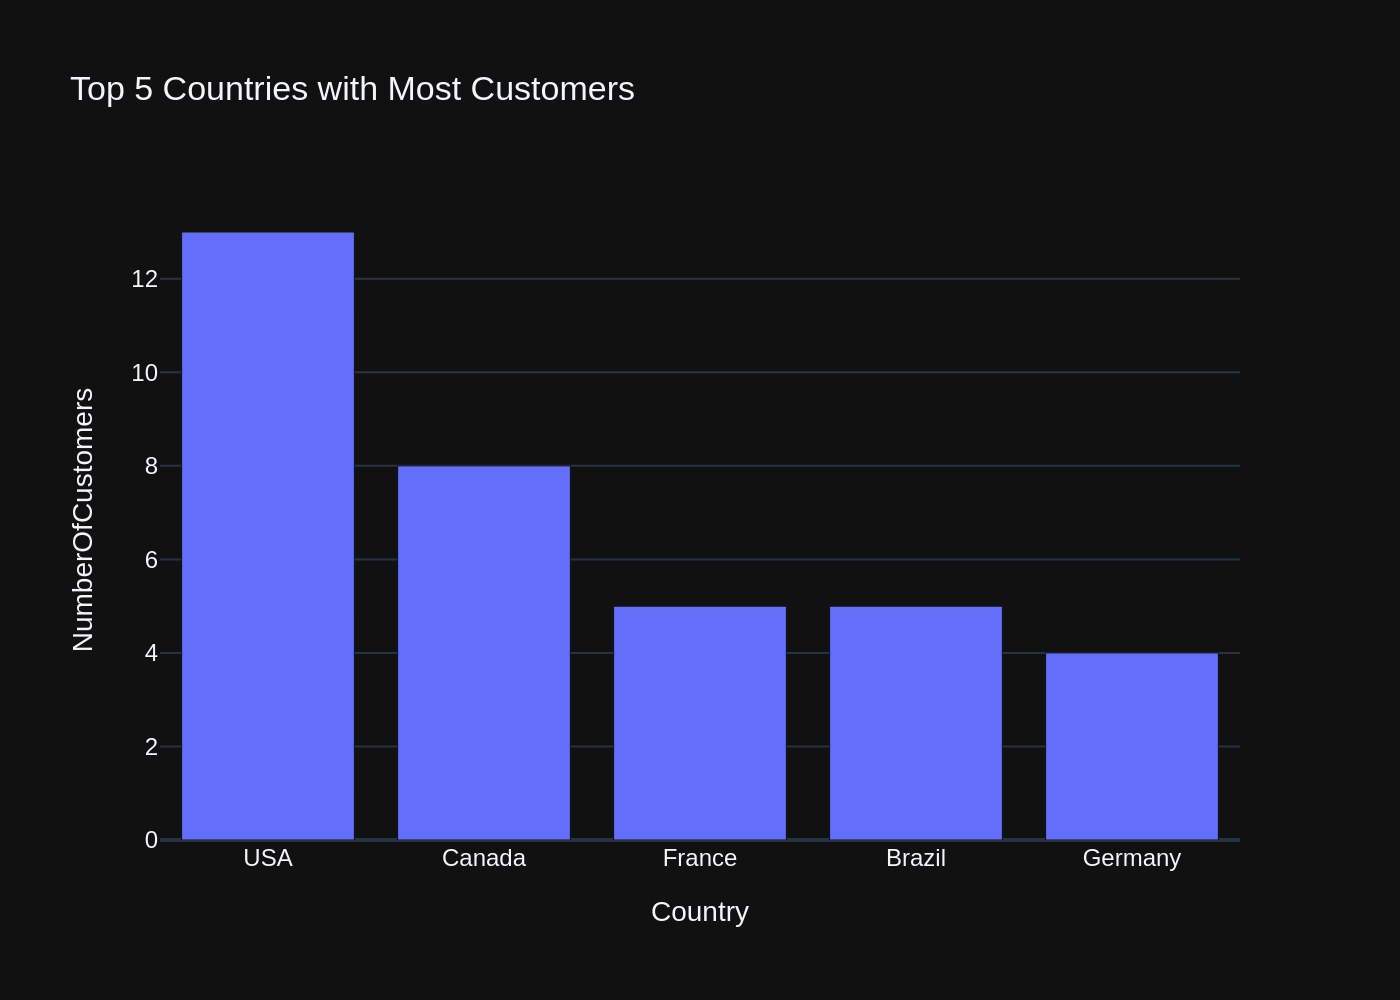





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model gpt-4 for 935.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT a.Title AS Album, ar.Name AS Artist
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Album,Artist
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave


Using model gpt-4 for 189.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Artist', y='Album', title='Albums per Artist')

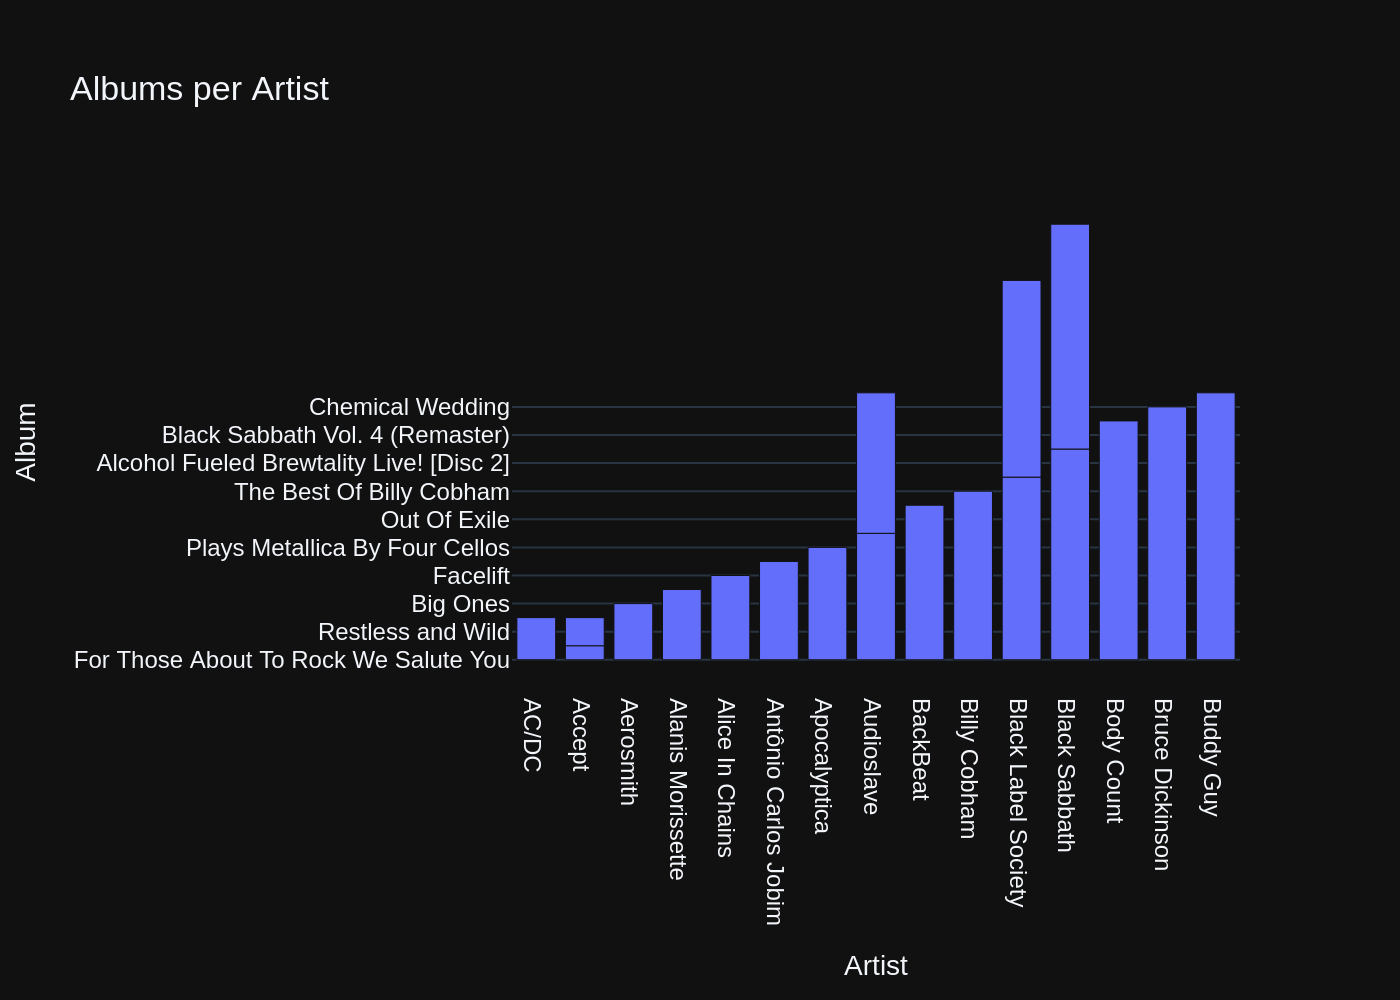





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model gpt-4 for 998.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM tracks 
WHERE Name LIKE '%What%' 
COLLATE NOCASE
LIMIT 20


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99


Using model gpt-4 for 228.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title="Single Value Indicator")
else:
    fig = px.bar(df, x='Name', y='Milliseconds', color='UnitPrice', 
                 labels={'Milliseconds':'Track Length (Milliseconds)', 'UnitPrice':'Unit Price'}, 
                 title='Track Information')

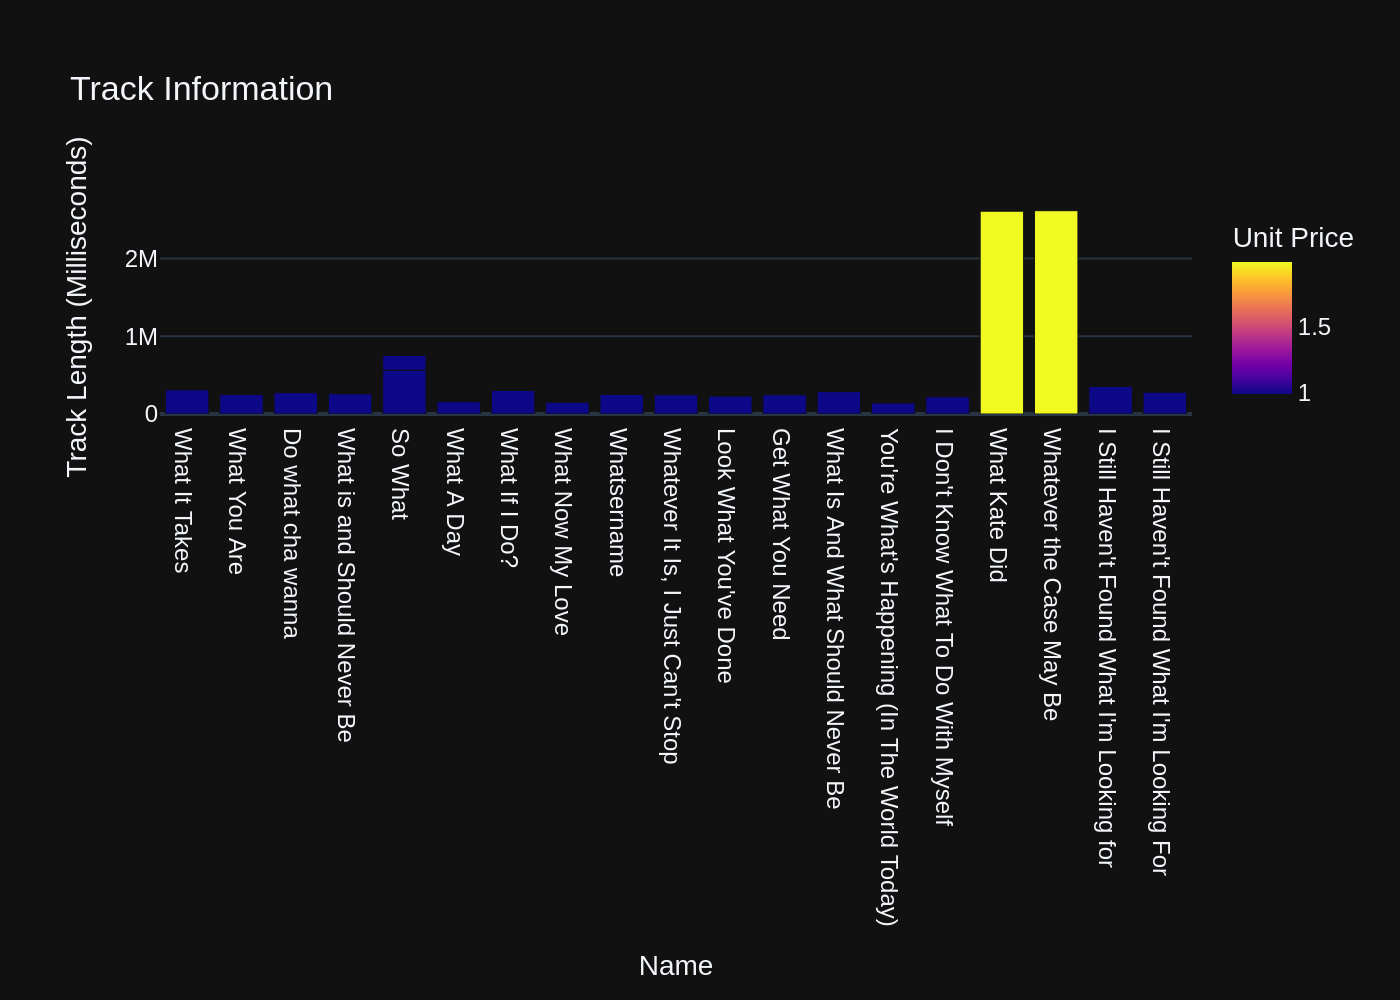





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model gpt-4 for 1383.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) as NumberOfInvoices 
FROM invoices 
GROUP BY CustomerId 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,NumberOfInvoices
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7


Using model gpt-4 for 188.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df['CustomerId'].unique()) == 1:
    fig = px.indicator(df, value='NumberOfInvoices', title="Total Number of Invoices")
else:
    fig = px.bar(df, x='CustomerId', y='NumberOfInvoices', title="Total Number of Invoices per Customer")

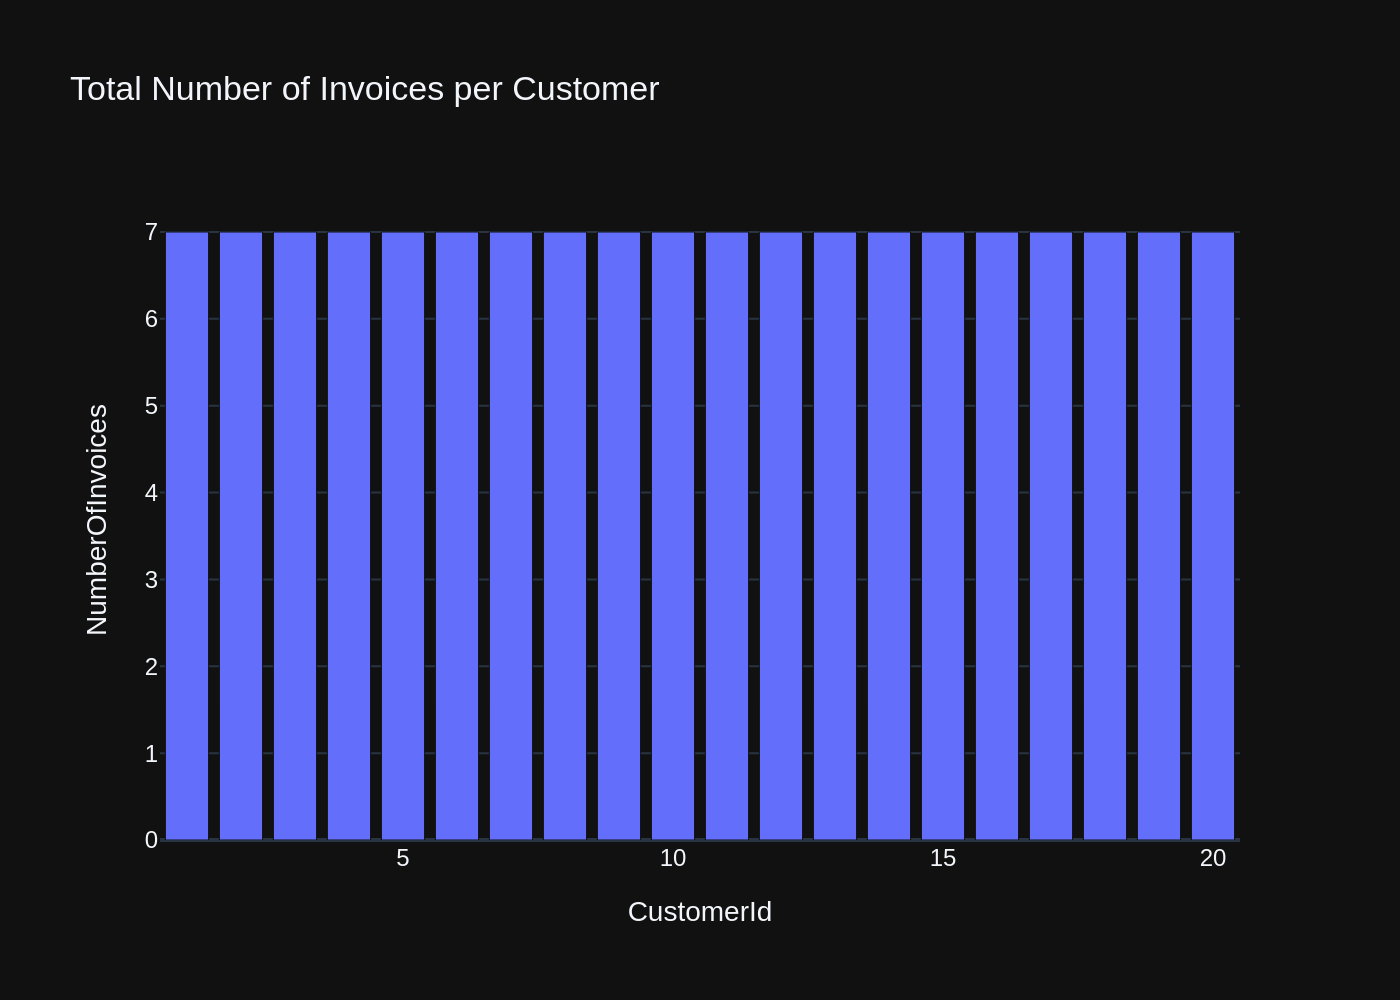





# QUESTION  - 9:  Find the total number of invoices per country


Using model gpt-4 for 1465.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.Country, COUNT(*) as NumberOfInvoices 
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
GROUP BY c.Country 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Country,NumberOfInvoices
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7


Using model gpt-4 for 199.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title = "Total Number of Invoices", value = 'NumberOfInvoices')
else:
    fig = px.bar(df, x='Country', y='NumberOfInvoices', title='Total Number of Invoices per Country')

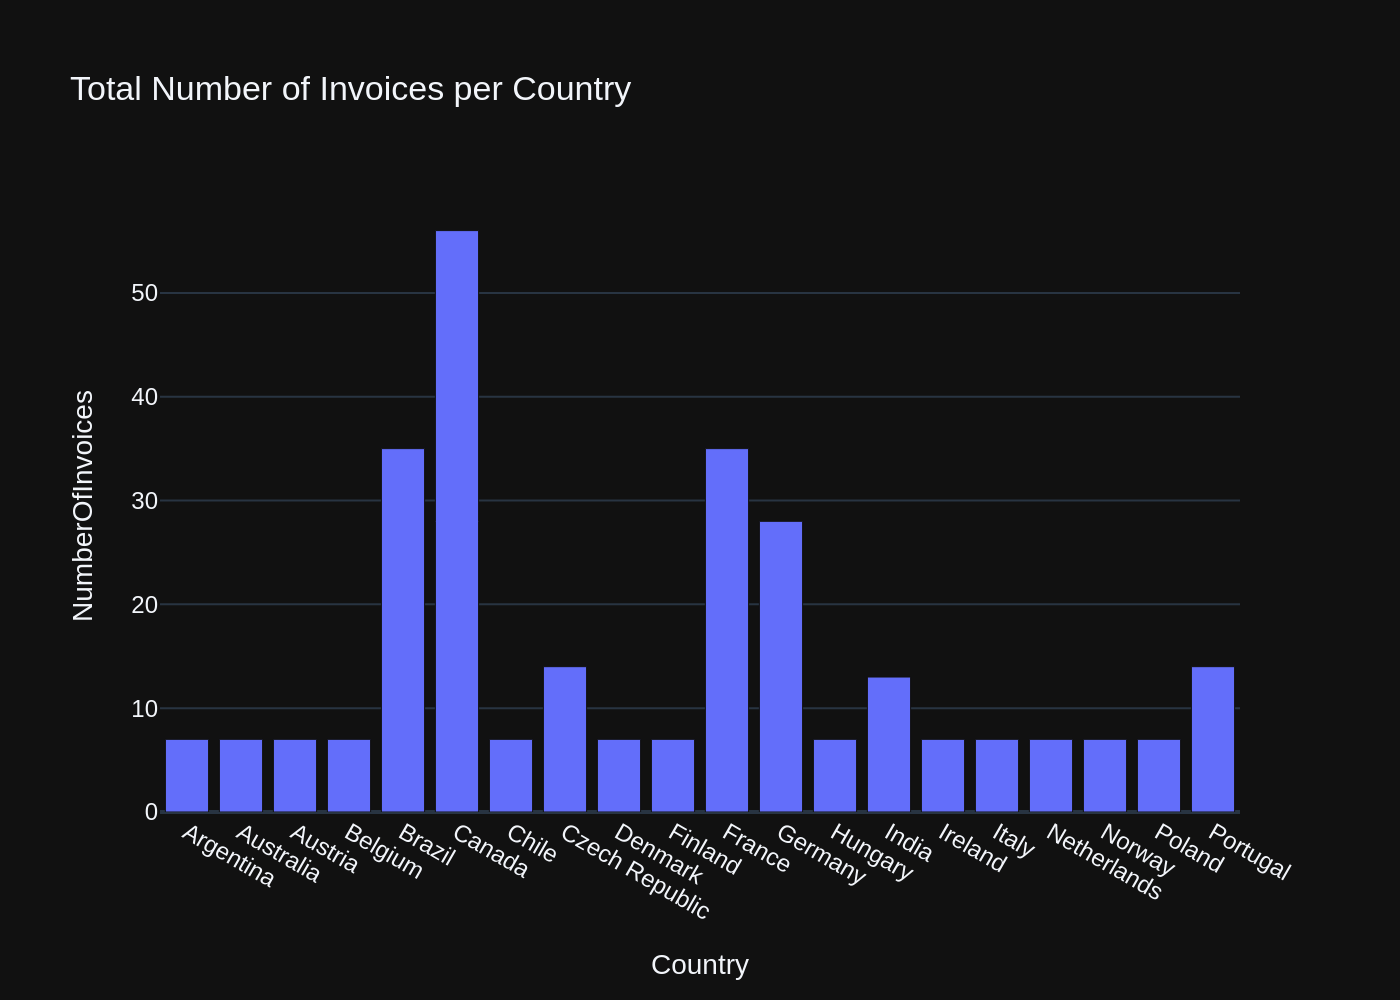





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model gpt-4 for 1464.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM invoices 
WHERE Total > 10 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86


Using model gpt-4 for 229.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title="Total", value="Total")
else:
    fig = px.bar(df, x='InvoiceId', y='Total', color='BillingCountry', 
                 labels={'Total':'Total Amount', 'InvoiceId':'Invoice ID', 'BillingCountry':'Billing Country'},
                 title='Invoices with Total Exceeding $10')

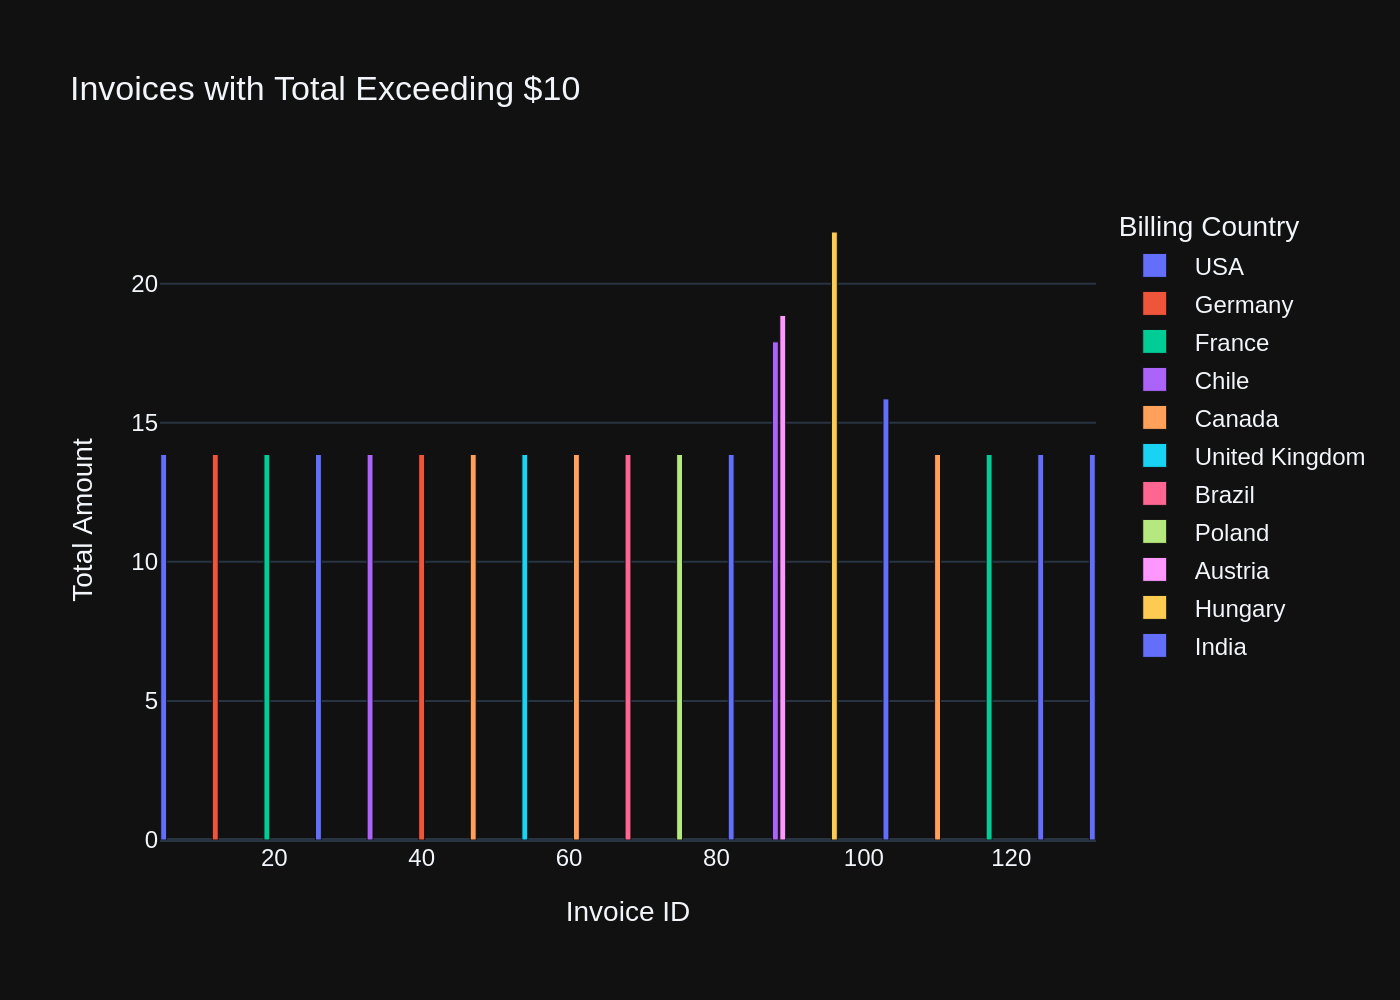





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model gpt-4 for 1619.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT InvoiceDate, SUM(Total) as TotalAmount
FROM invoices
WHERE InvoiceDate >= '2010-01-01'
GROUP BY InvoiceDate
LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceDate,TotalAmount
0,2010-01-08 00:00:00,3.96
1,2010-01-09 00:00:00,3.96
2,2010-01-10 00:00:00,6.94
3,2010-01-13 00:00:00,17.91
4,2010-01-18 00:00:00,18.86
5,2010-01-26 00:00:00,0.99
6,2010-02-08 00:00:00,3.96
7,2010-02-09 00:00:00,3.96
8,2010-02-10 00:00:00,5.94
9,2010-02-13 00:00:00,8.91


Using model gpt-4 for 197.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalAmount'].values[0]
    ))
else:
    fig = go.Figure(data=go.Scatter(x=df['InvoiceDate'], y=df['TotalAmount'], mode='lines+markers'))

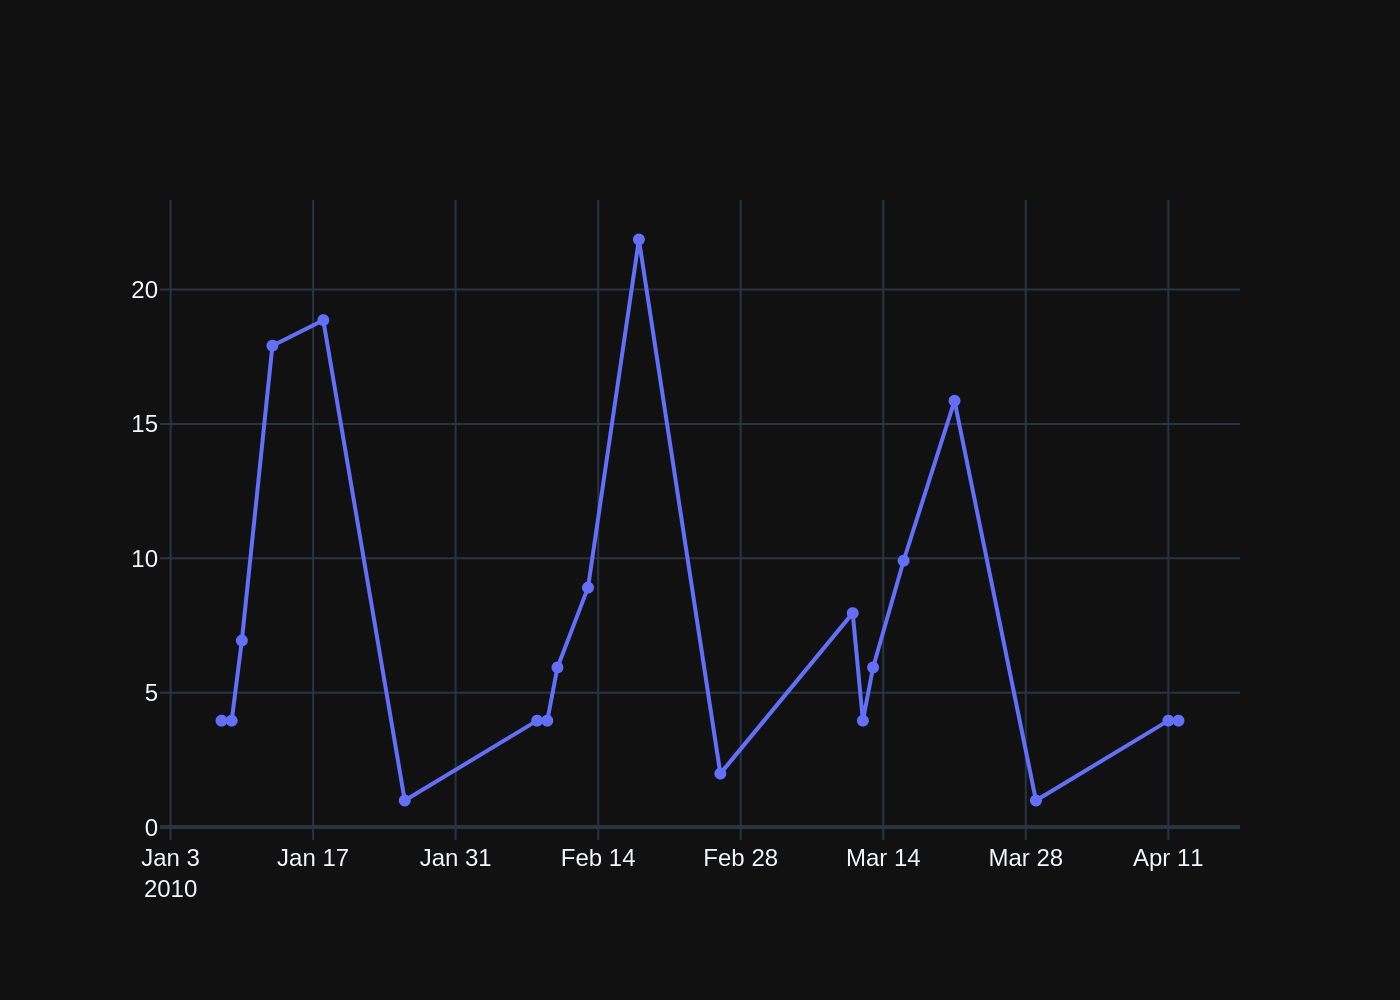





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model gpt-4 for 1591.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT e1.FirstName || ' ' || e1.LastName AS EmployeeName, 
       e2.FirstName || ' ' || e2.LastName AS ManagerName
FROM employees e1
LEFT JOIN employees e2 ON e1.ReportsTo = e2.EmployeeId
LIMIT 20


[( <DataFrame> )]
queried dataframe



,EmployeeName,ManagerName
0,Andrew Adams,None
1,Nancy Edwards,Andrew Adams
2,Jane Peacock,Nancy Edwards
3,Margaret Park,Nancy Edwards
4,Steve Johnson,Nancy Edwards
5,Michael Mitchell,Andrew Adams
6,Robert King,Michael Mitchell
7,Laura Callahan,Michael Mitchell


Using model gpt-4 for 216.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df['EmployeeName'].unique()) == 1:
    fig = px.indicator(df, title='Manager Name', value='ManagerName')
else:
    fig = px.bar(df, x='EmployeeName', y='ManagerName', title='Employees and their Reporting Manager')

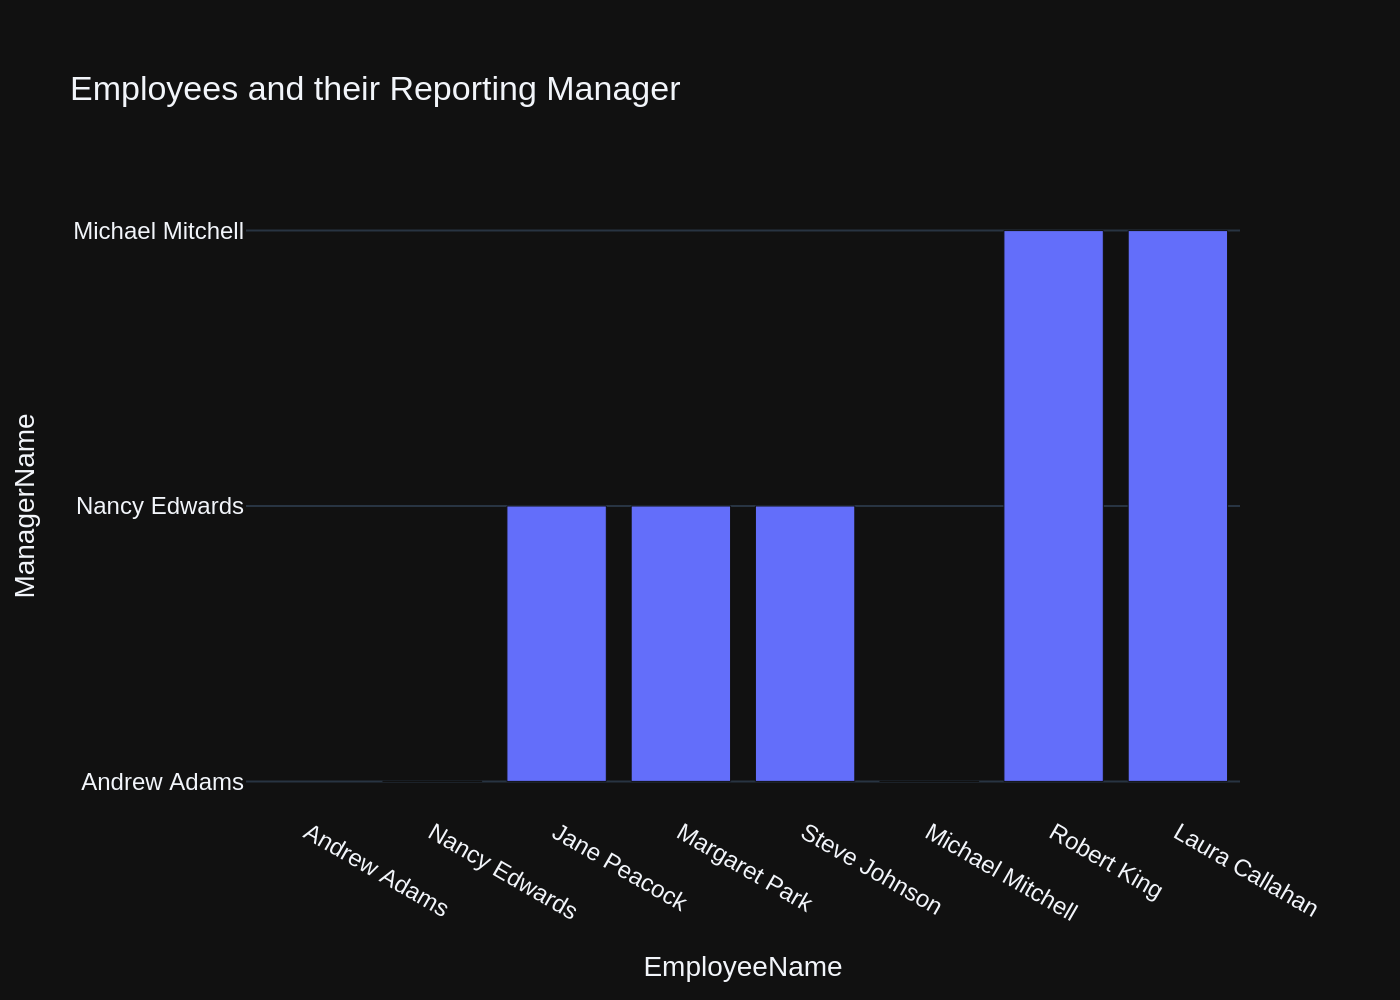





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model gpt-4 for 1420.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, AVG(Total) as AverageInvoiceTotal 
FROM invoices 
GROUP BY CustomerId 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,AverageInvoiceTotal
0,1,5.660000
1,2,5.374286
2,3,5.660000
3,4,5.660000
4,5,5.802857
5,6,7.088571
6,7,6.088571
7,8,5.374286
8,9,5.374286
9,10,5.374286


Using model gpt-4 for 192.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df['CustomerId'].unique()) == 1:
    fig = px.indicator(df, value='AverageInvoiceTotal', title="Average Invoice Total")
else:
    fig = px.bar(df, x='CustomerId', y='AverageInvoiceTotal', title="Average Invoice Total per Customer")

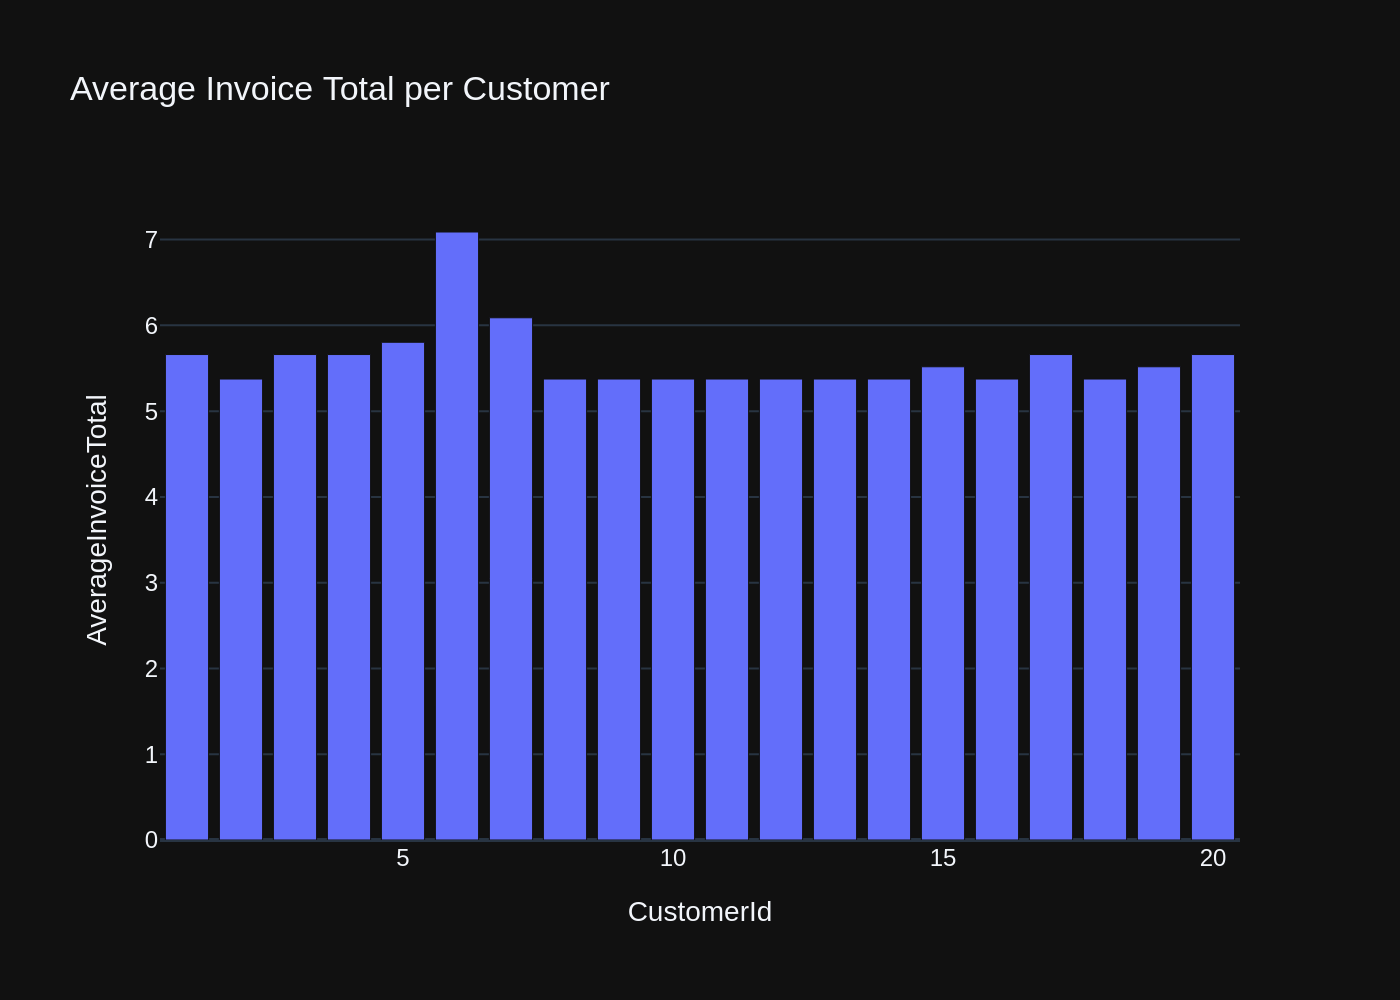





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model gpt-4 for 1152.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM tracks 
ORDER BY UnitPrice DESC 
LIMIT 5


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,226,3,18,None,2622250,490750393,1.99
1,2820,Occupation / Precipice,227,3,19,None,5286953,1054423946,1.99
2,2821,"Exodus, Pt. 1",227,3,19,None,2621708,475079441,1.99
3,2822,"Exodus, Pt. 2",227,3,19,None,2618000,466820021,1.99
4,2823,Collaborators,227,3,19,None,2626626,483484911,1.99


Using model gpt-4 for 222.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title = "Most Expensive Track", value = "UnitPrice")
else:
    fig = px.bar(df, x='Name', y='UnitPrice', title='Top 5 Most Expensive Tracks')

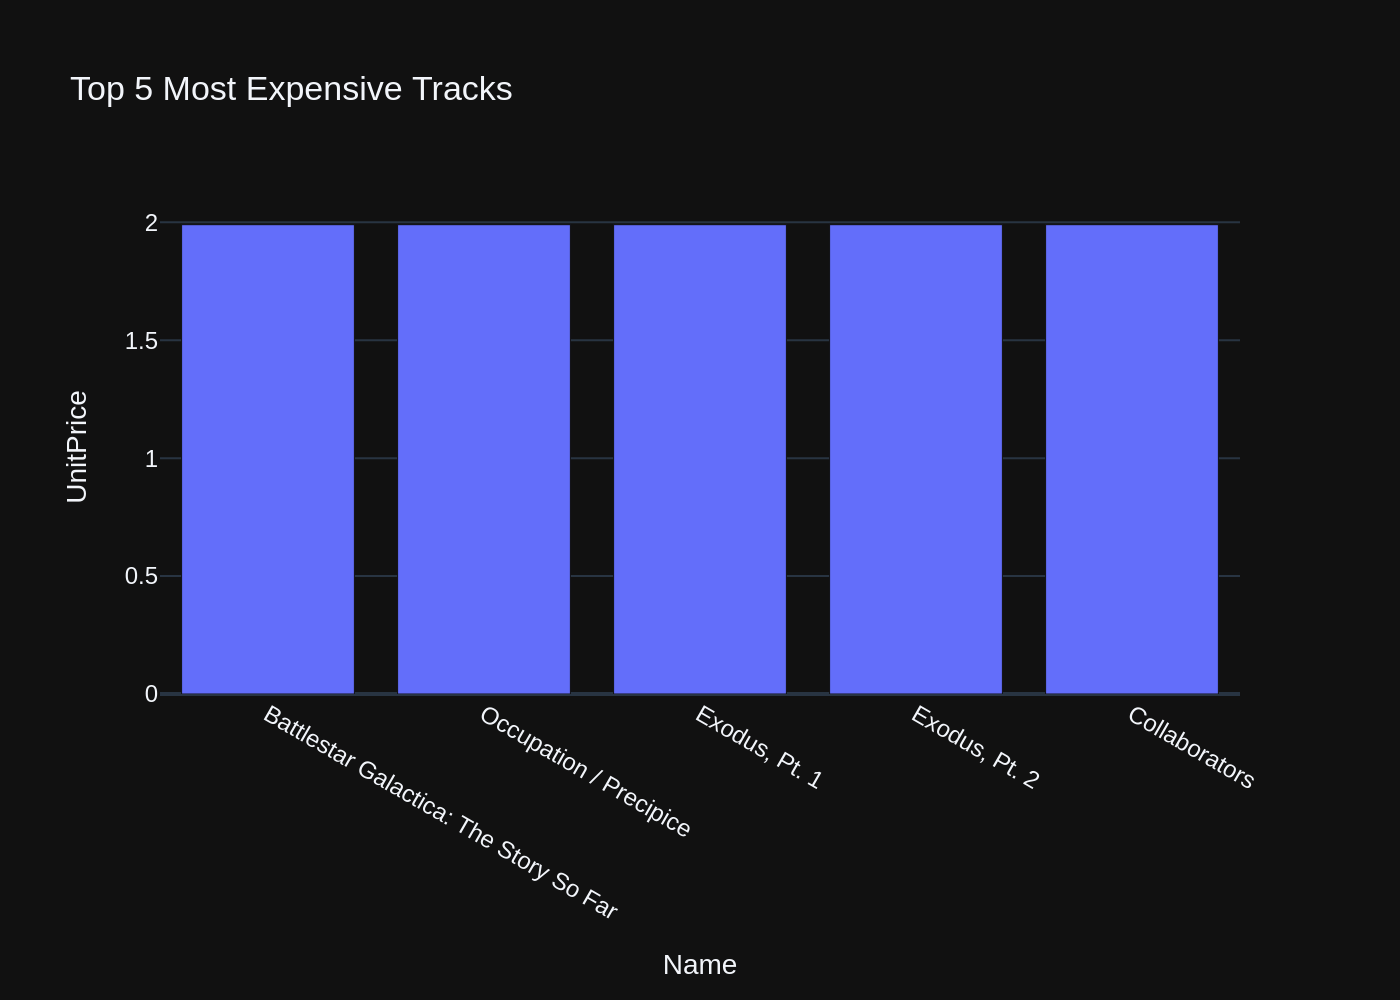





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model gpt-4 for 1071.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name as Genre, COUNT(t.TrackId) as NumberOfTracks
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.Name
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Genre,NumberOfTracks
0,Alternative,40
1,Alternative & Punk,332
2,Blues,81
3,Bossa Nova,15
4,Classical,74
5,Comedy,17
6,Drama,64
7,Easy Listening,24
8,Electronica/Dance,30
9,Heavy Metal,28


Using model gpt-4 for 200.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, value='NumberOfTracks', title='Number of Tracks', 
                       labels={'NumberOfTracks': df['Genre'].values[0]})
else:
    fig = px.bar(df, x='Genre', y='NumberOfTracks', labels={'Genre':'Genre', 'NumberOfTracks':'Number of Tracks'})

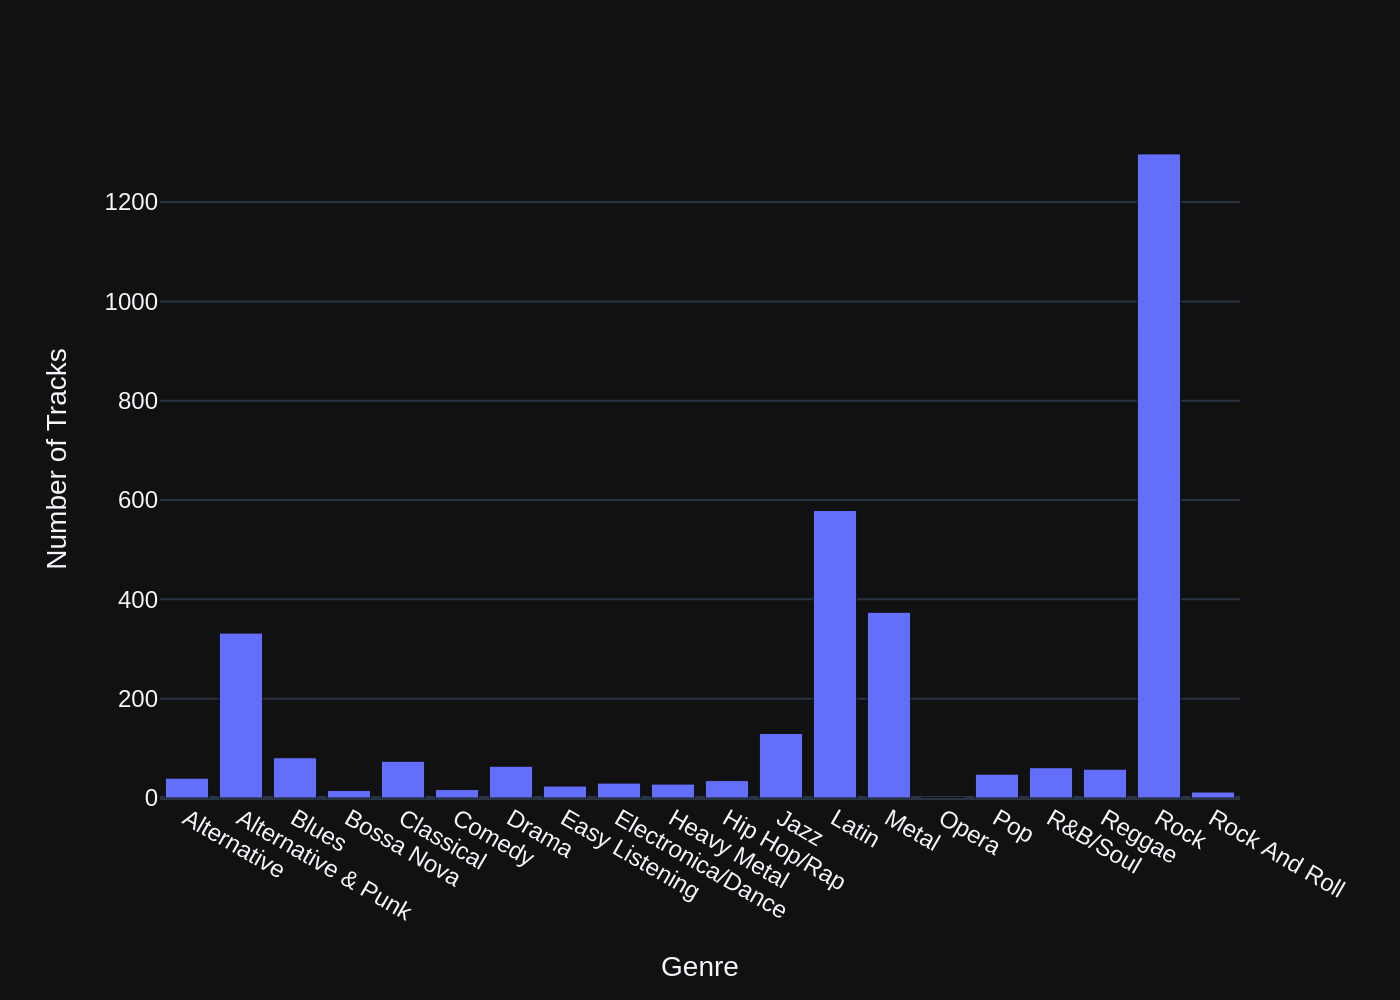





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model gpt-4 for 1104.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name as Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Genre



[( RETRY )]
***** 1 *****

Using model gpt-4 for 1366.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 2 *****

Using model gpt-4 for 1413.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 3 *****

Using model gpt-4 for 1473.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Name






# QUESTION  - 17:  List all customers who have not placed any orders:


Using model gpt-4 for 1714.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 1 *****

Using model gpt-4 for 1581.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 2 *****

Using model gpt-4 for 1621.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 3 *****

Using model gpt-4 for 1681.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model gpt-4 for 1135.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT ar.Name as Artist, COUNT(*) as NumberOfTracks
FROM tracks t
JOIN albums a ON t.AlbumId = a.AlbumId
JOIN artists ar ON a.ArtistId = ar.ArtistId
GROUP BY ar.Name
ORDER BY NumberOfTracks DESC
LIMIT 10


[( <DataFrame> )]
queried dataframe



,Artist,NumberOfTracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
5,Deep Purple,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model gpt-4 for 266.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Artist', y='NumberOfTracks', title='Top 10 Most Popular Artists Based on Number of Tracks')

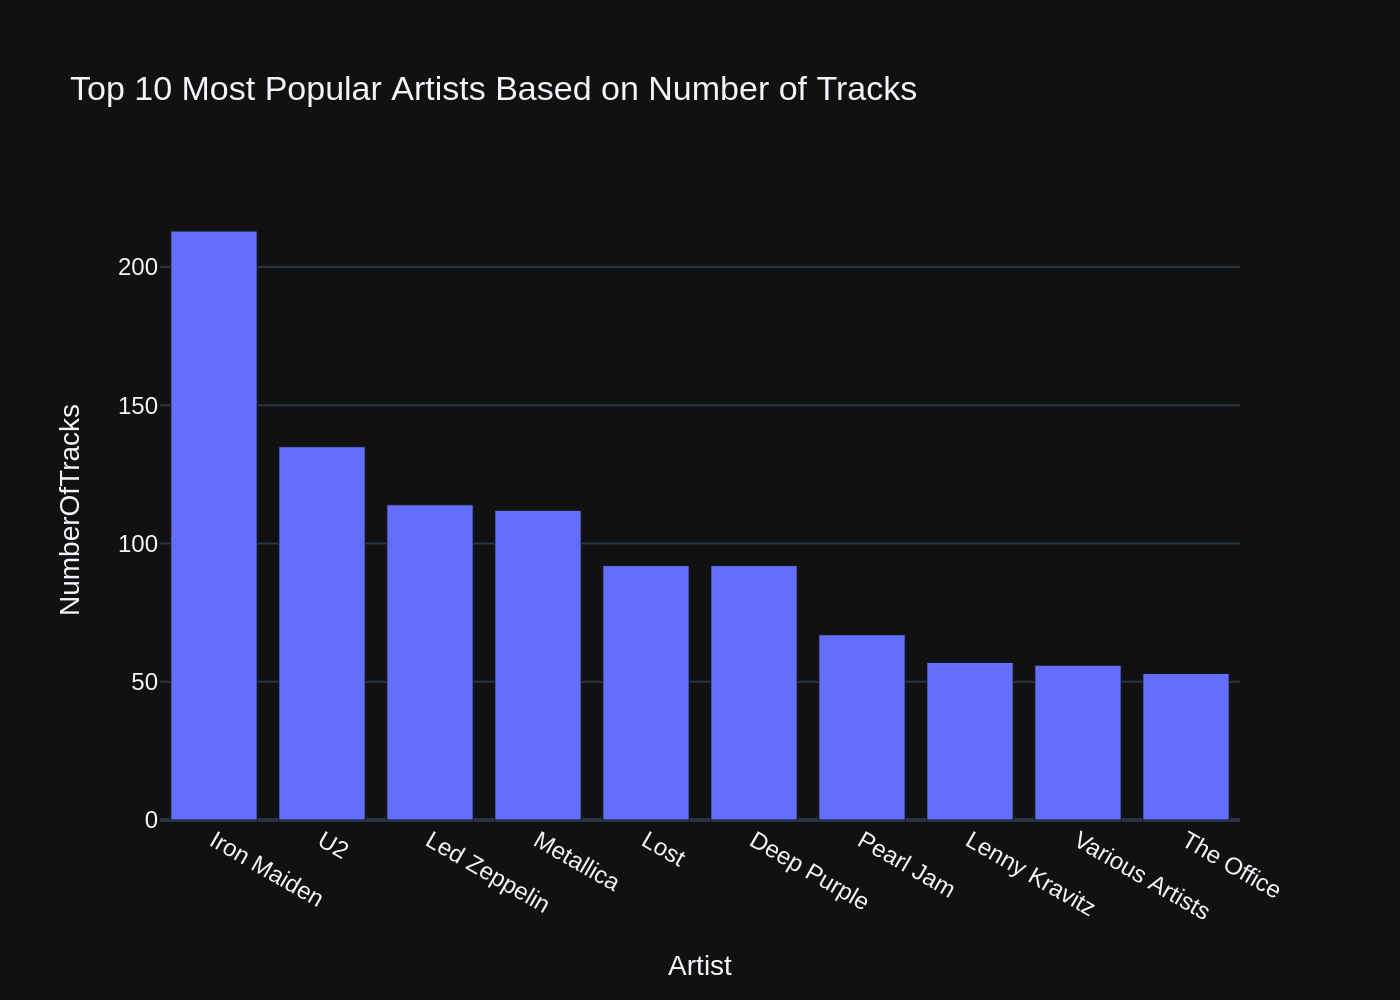





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model gpt-4 for 1539.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email 
FROM customers 
WHERE Country = 'Canada' 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca


Using model gpt-4 for 190.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df.iloc[0]['Email']
    ))
else:
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df.FirstName, df.LastName, df.Email],
                   fill_color='lavender',
                   align='left'))
    ])

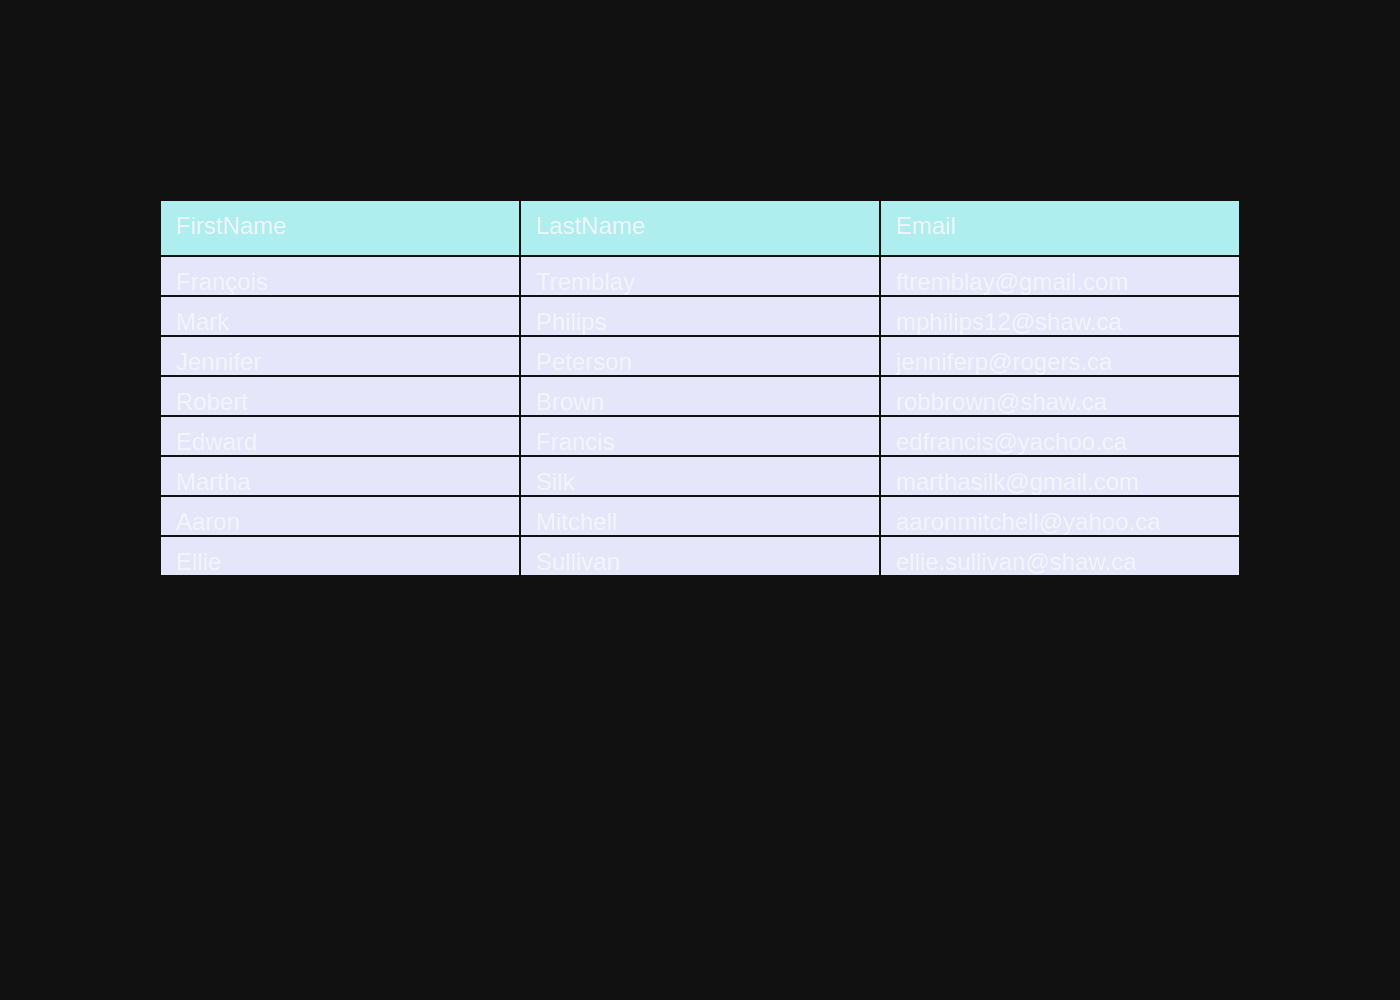





# QUESTION  - 20:  Find the customer with the most invoices 


Using model gpt-4 for 1457.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) as NumberOfInvoices 
FROM invoices 
GROUP BY CustomerId 
ORDER BY NumberOfInvoices DESC 
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,NumberOfInvoices
0,1,7


Using model gpt-4 for 194.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['NumberOfInvoices'].values[0],
    title = {"text": f"Customer {df['CustomerId'].values[0]}"}))

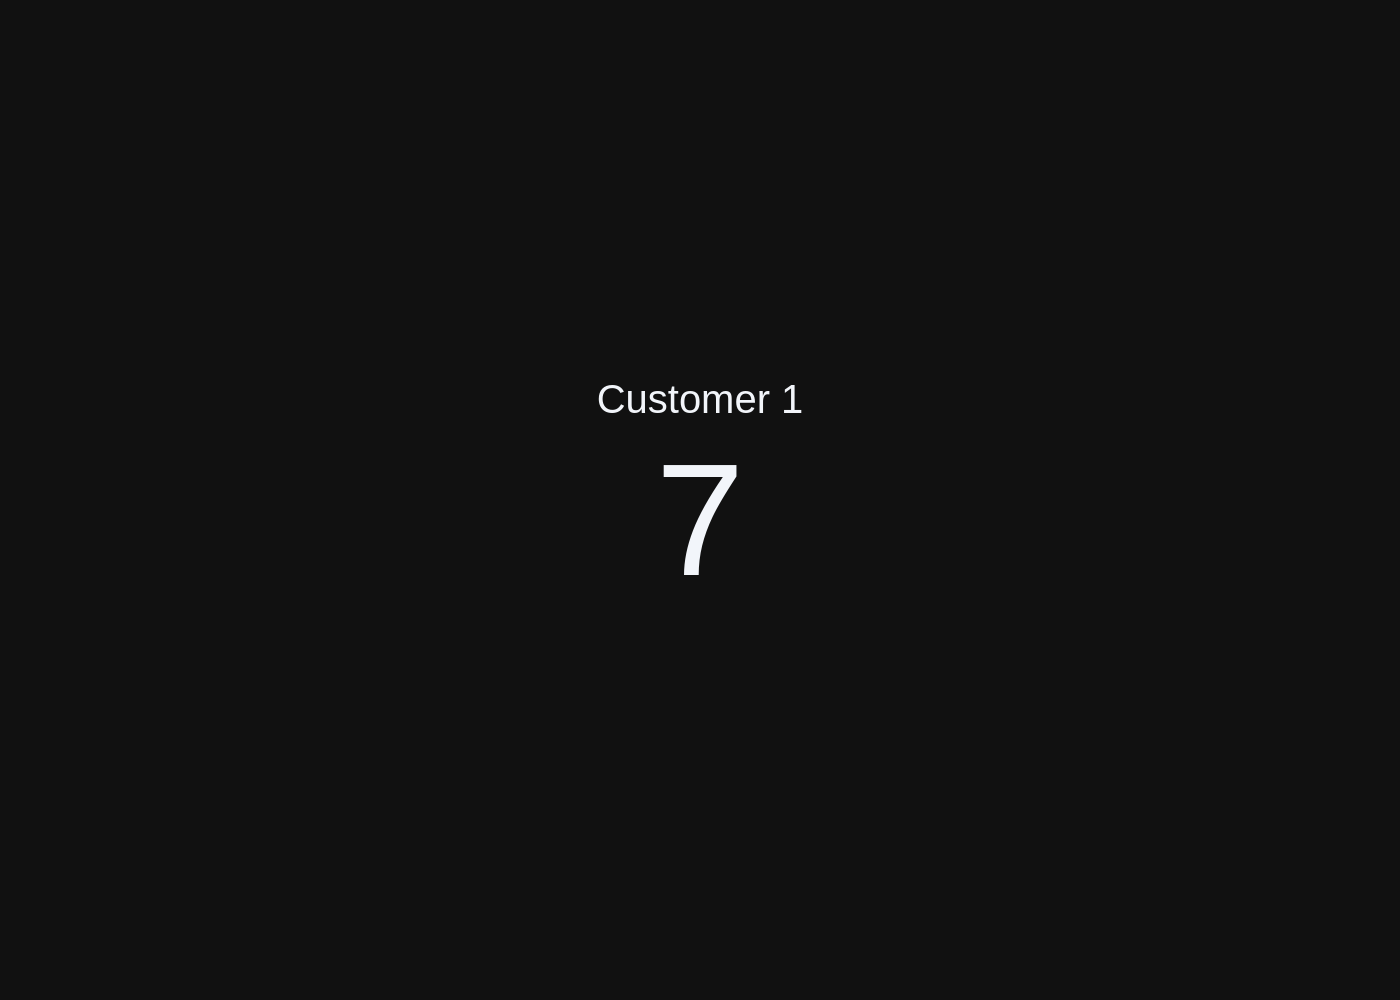





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model gpt-4 for 1305.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT i.CustomerId, SUM(ii.Quantity) as TotalQuantity
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
GROUP BY i.CustomerId
ORDER BY TotalQuantity DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalQuantity
0,1,38


Using model gpt-4 for 217.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['TotalQuantity'].values[0],
    title = {"text": f"Total Albums Bought by Customer {df['CustomerId'].values[0]}"},
))

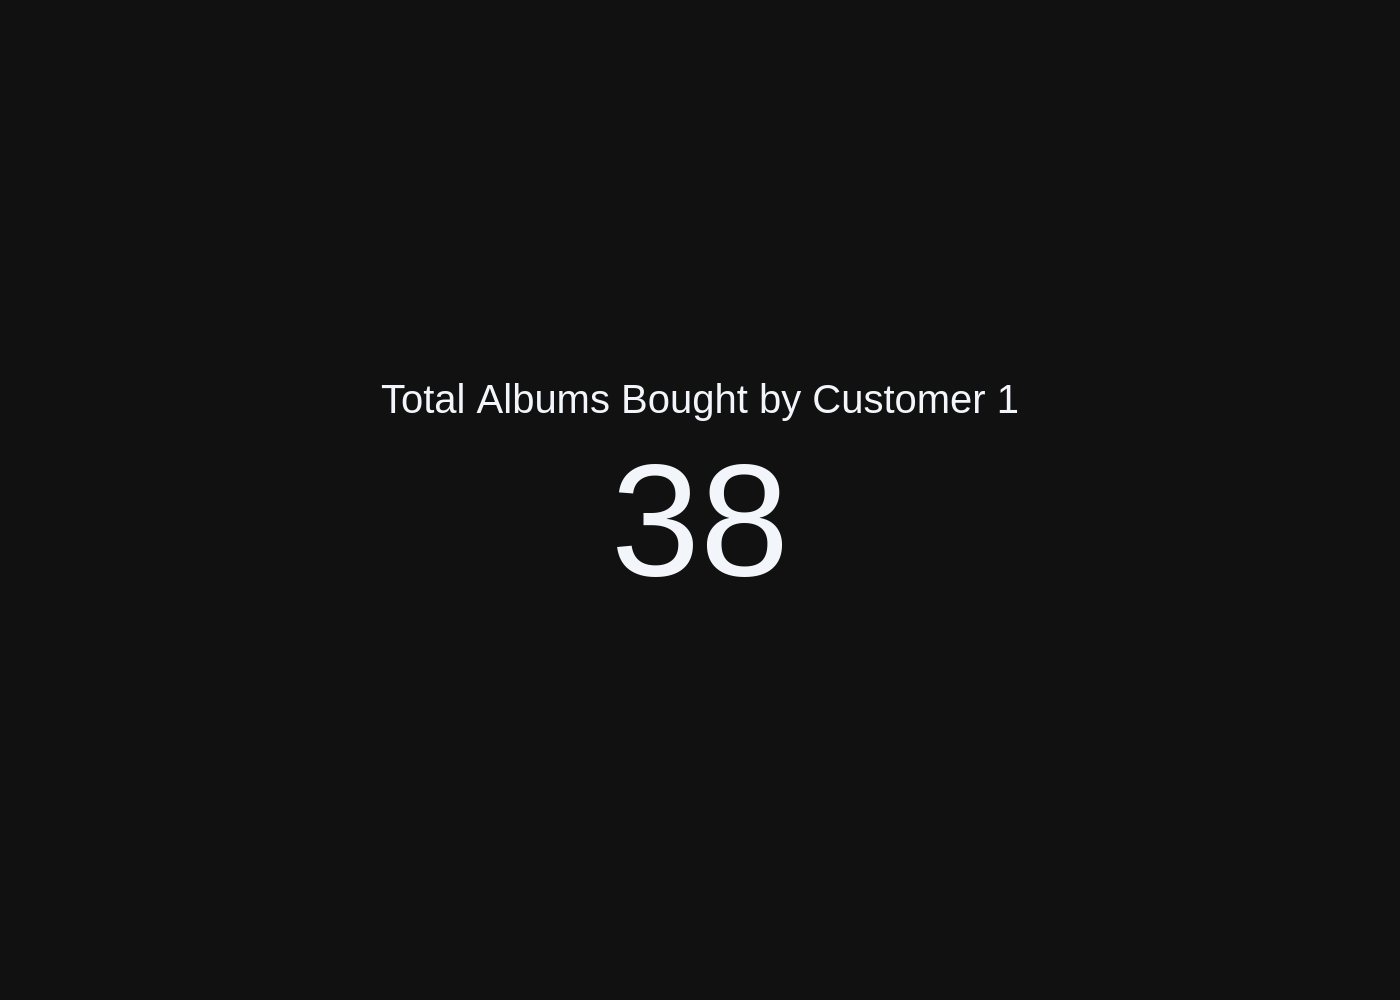





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model gpt-4 for 1348.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT i.CustomerId, SUM(ii.Quantity) as TotalQuantity
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
GROUP BY i.CustomerId
ORDER BY TotalQuantity DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalQuantity
0,1,38
1,2,38
2,3,38
3,4,38
4,5,38


Using model gpt-4 for 238.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, value='TotalQuantity', title='Total Quantity of Albums Bought by Customer')
else:
    fig = px.bar(df, x='CustomerId', y='TotalQuantity', title='Top 5 Customers Who Bought the Most Albums')

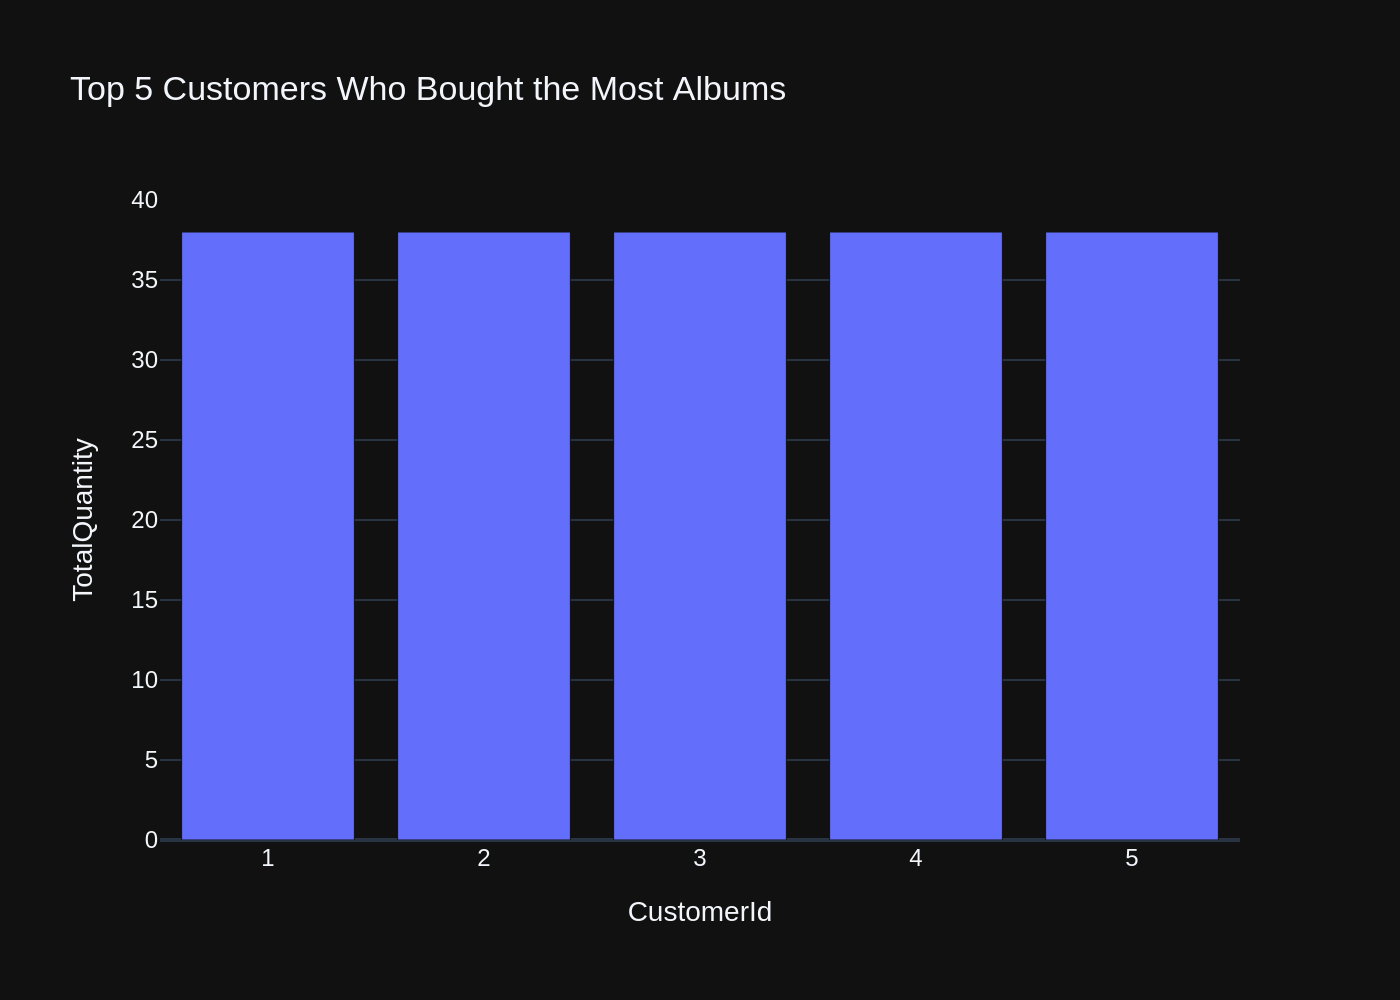





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model gpt-4 for 1604.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, SUM(Total) as TotalSpent
FROM invoices
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalSpent
0,6,49.62
1,26,47.62
2,57,46.62
3,45,45.62
4,46,45.62


Using model gpt-4 for 227.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='CustomerId', y='TotalSpent', title='Top 5 Customers Who Spent the Most Money')

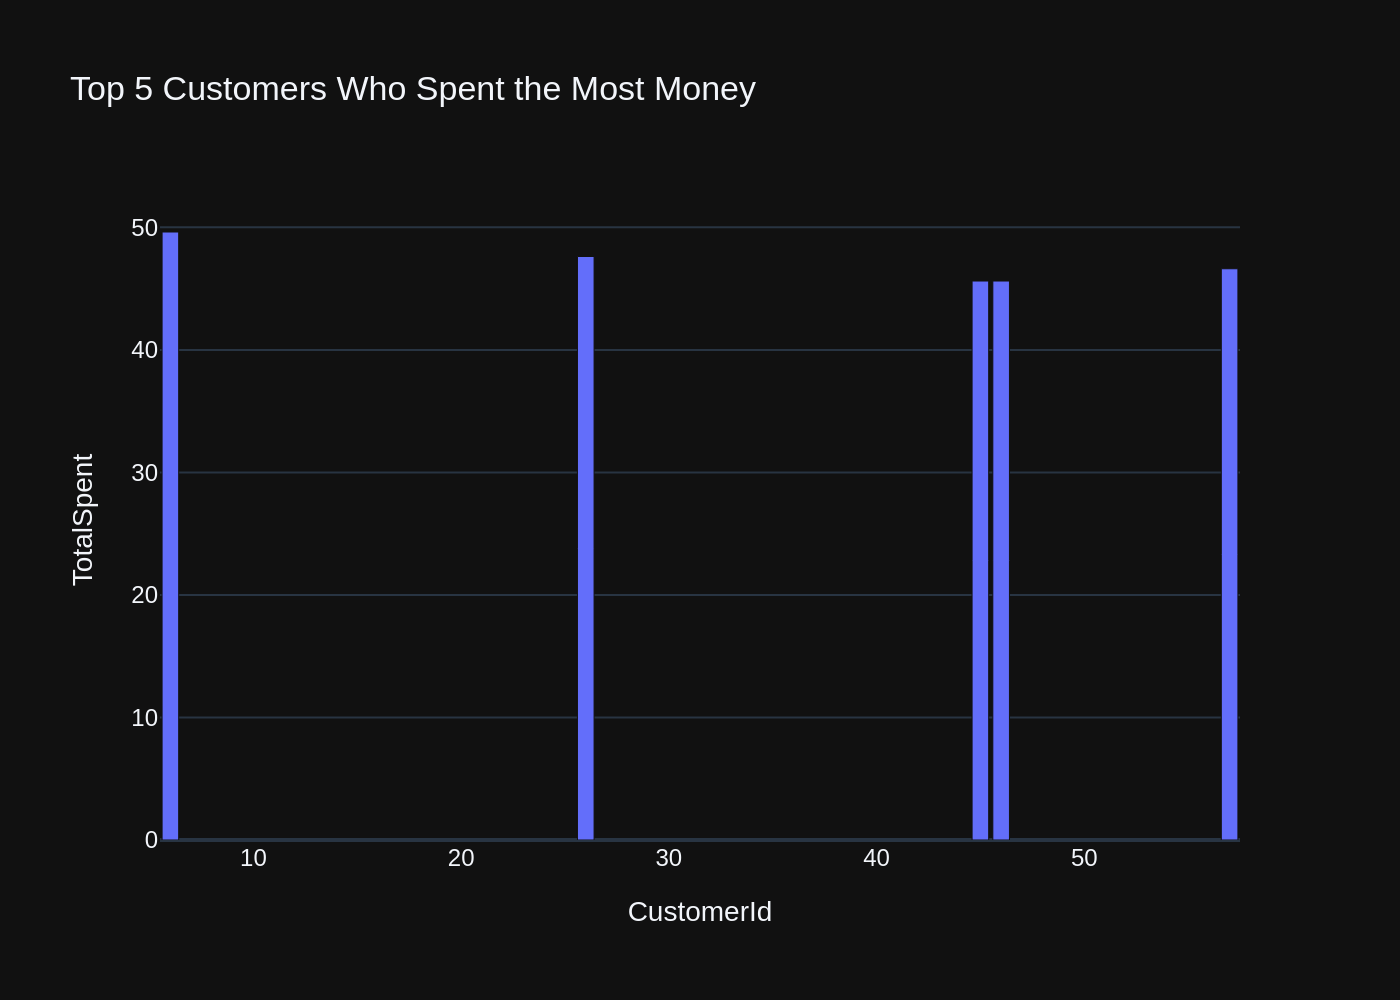





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model gpt-4 for 1252.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT p.PlaylistId, p.Name, COUNT(pt.TrackId) as NumberOfTracks, SUM(t.Milliseconds) as TotalDuration
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId, p.Name
HAVING COUNT(pt.TrackId) >= 10
LIMIT 20


[( <DataFrame> )]
queried dataframe



,PlaylistId,Name,NumberOfTracks,TotalDuration
0,1,Music,3290,877683083
1,3,TV Shows,213,501094957
2,5,90’s Music,1477,398705153
3,8,Music,3290,877683083
4,10,TV Shows,213,501094957
5,11,Brazilian Music,39,9486559
6,12,Classical,75,21770592
7,13,Classical 101 - Deep Cuts,25,6755730
8,14,Classical 101 - Next Steps,25,7575051
9,15,Classical 101 - The Basics,25,7439811


Using model gpt-4 for 257.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Name', y='NumberOfTracks', color='TotalDuration', title='Playlists with at least 10 tracks and their total duration')

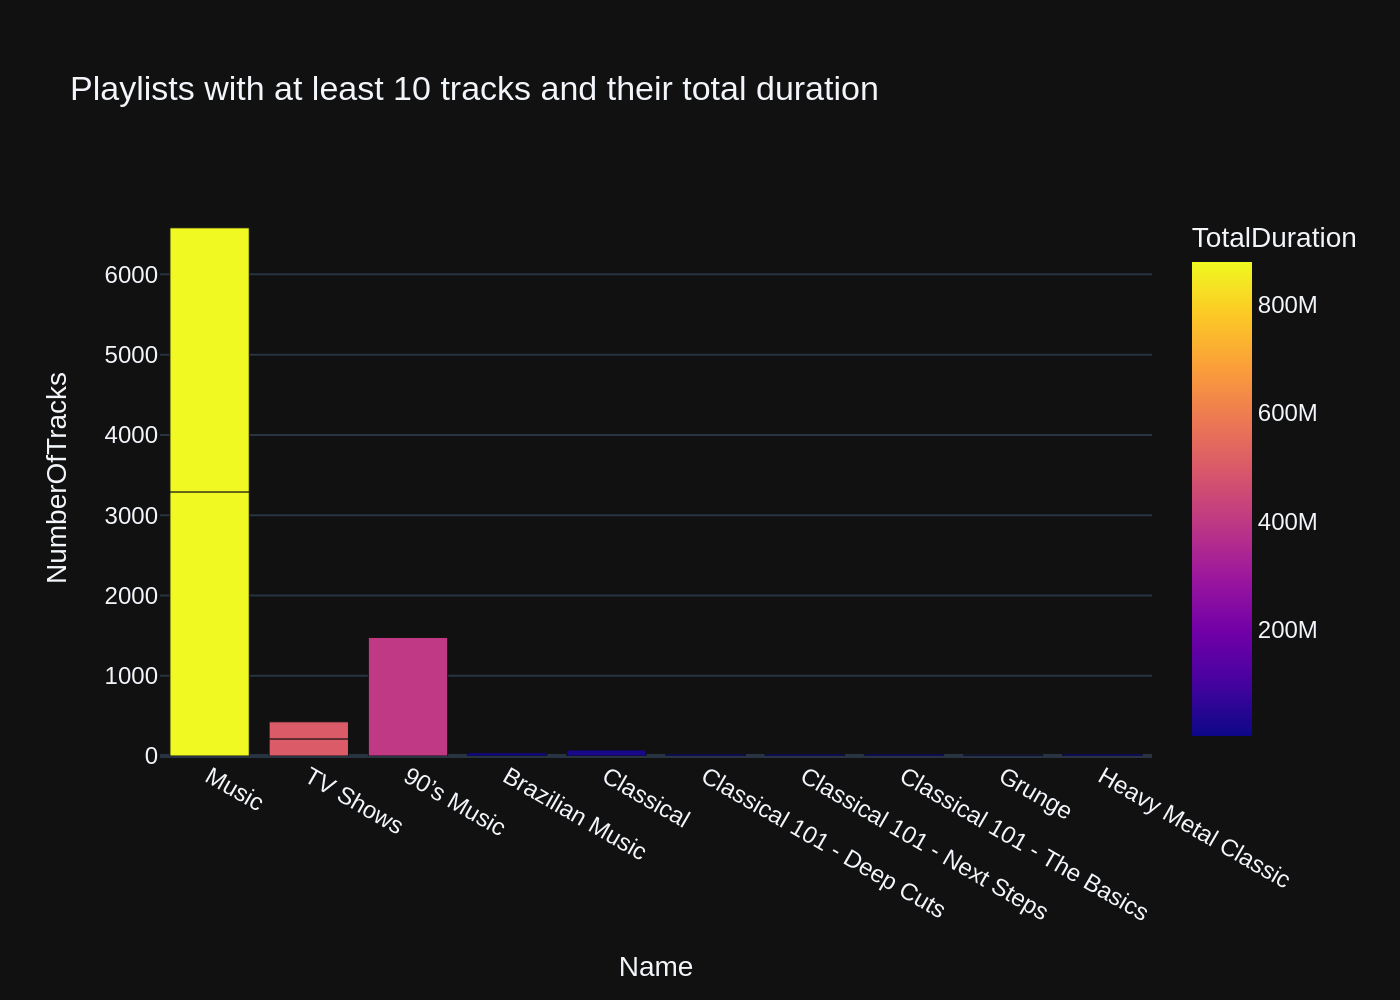





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model gpt-4 for 1315.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT ar.Name as Artist
FROM artists ar
JOIN albums a ON ar.ArtistId = a.ArtistId
JOIN tracks t ON a.AlbumId = t.AlbumId
GROUP BY ar.Name
HAVING COUNT(DISTINCT t.GenreId) > 1
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Artist
0,Amy Winehouse
1,Antônio Carlos Jobim
2,Audioslave
3,Battlestar Galactica
4,Eric Clapton
5,Faith No More
6,Foo Fighters
7,Gilberto Gil
8,Guns N' Roses
9,Heroes


Using model gpt-4 for 208.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df['Artist'].unique()) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['Artist'].value_counts().values[0],
        title = {"text": df['Artist'].values[0]}))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['Artist'],
        y=df['Artist'].value_counts().values,
        text=df['Artist'].value_counts().values,
        textposition='auto',
    )])

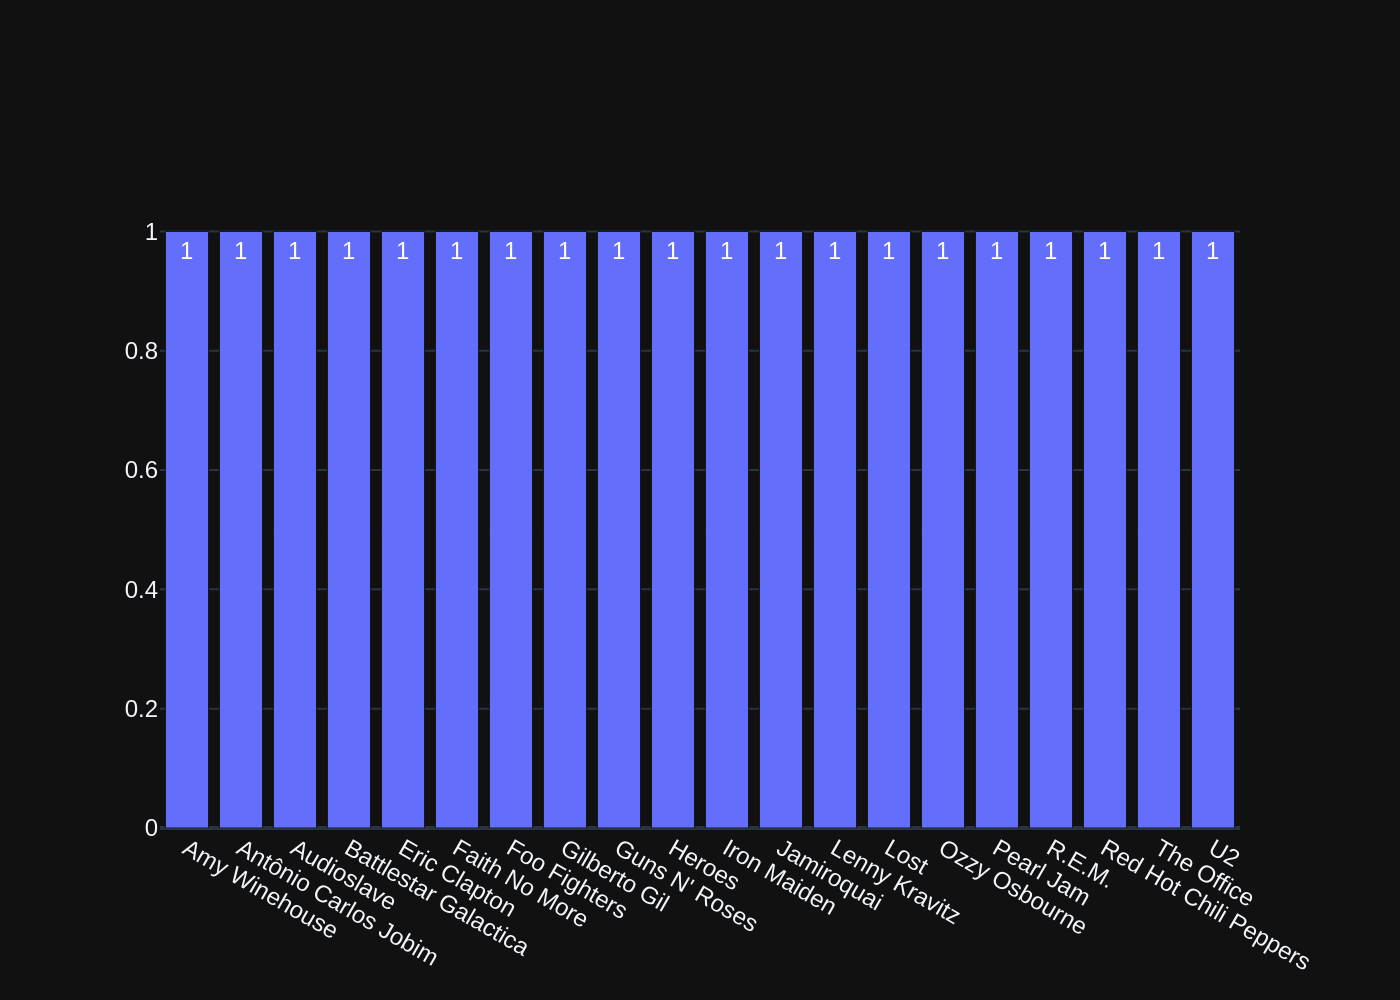

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gpt-4' 
 took 293 sec
 run on 'ducklover1' 
 at 20241122-230521


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gpt-4-293s-ducklover1-20241122-230521.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,039b490a-6b1c-59b0-bf59-4dabace53c75-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email \nFROM custo...",sql
1,09244fbf-7b47-5bea-a3fc-e419c20e4366-sql,Find the top 5 most expensive tracks (based on...,SELECT * \nFROM tracks \nORDER BY UnitPrice DE...,sql
2,0eb0b1cb-152c-5c2c-9235-491007a9fcb6-sql,\n Find the top 5 customers who b...,"SELECT i.CustomerId, SUM(ii.Quantity) as Total...",sql
3,2b65c1c4-ff74-5b15-be07-143d624f990a-sql,Get the average invoice total for each customer:,"SELECT CustomerId, AVG(Total) as AverageInvoic...",sql
4,2d7363bf-ba0a-57de-ade1-db647d6264a3-sql,"Find all tracks with a name containing ""What"" ...",SELECT * \nFROM tracks \nWHERE Name LIKE '%Wha...,sql
5,3e2b0f53-fa5a-5065-ab3e-264a2f53b80b-sql,Get all playlists containing at least 10 track...,"SELECT p.PlaylistId, p.Name, COUNT(pt.TrackId)...",sql
6,50bbc8c8-d201-5c9a-bca7-8fa8f7c5e1d7-sql,Find all invoices since 2010 and the total amo...,"SELECT InvoiceDate, SUM(Total) as TotalAmount\...",sql
7,55ba17ae-bd10-58ef-ab2f-35afebdf9013-sql,List all employees and their reporting manager...,SELECT e1.FirstName || ' ' || e1.LastName AS E...,sql
8,5c21a5d8-4c12-5705-8fed-5d9584d401e4-sql,\n Generating SQL for this ...,SELECT * FROM invoices LIMIT 20,sql
9,5e526ae4-4473-5cc5-9185-b16c465687c0-sql,How many customers are there,SELECT COUNT(*) FROM customers LIMIT 20,sql


In [22]:
df_training_data.to_csv(file_csv, index=False)